# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from sklearn.preprocessing import LabelEncoder

import haversine as hs
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

# Load in KC House Data

In [2]:
# Read in kc_house_data
df = pd.read_csv('data/kc_house_data.csv')

# Peek at data types and first few rows of dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

Based on the above, the column **sqft_basement** is a column to inspect given it is an object type, and it is expected to be at least an int or float type

## Data Quality Check

In [3]:
# Peek at data
df[['sqft_basement']].head()

sqft_basement
0           0.0
1         400.0
2           0.0
3         910.0
4           0.0

Based on the above, expected datatype is perhaps a float type.

In [4]:
errors = []
for idx, value in enumerate(df.sqft_basement):
    try:
        float(value)
    except:
        errors.append(idx)

In [5]:
# Filter and check for errors

sqft_error_df = df.iloc[errors, :]
print(sqft_error_df.shape)
sqft_error_df

(454, 21)


id        date      price  bedrooms  bathrooms  sqft_living  \
6      1321400060   6/27/2014   257500.0         3       2.25         1715   
18       16000397   12/5/2014   189000.0         2       1.00         1200   
42     7203220400    7/7/2014   861990.0         5       2.75         3595   
79     1531000030   3/23/2015   720000.0         4       2.50         3450   
112    2525310310   9/16/2014   272500.0         3       1.75         1540   
...           ...         ...        ...       ...        ...          ...   
21442  3226049565   7/11/2014   504600.0         5       3.00         2360   
21447  1760650900   7/21/2014   337500.0         4       2.50         2330   
21473  6021503707   1/20/2015   352500.0         2       2.50          980   
21519  2909310100  10/15/2014   332000.0         4       2.50         2380   
21581   191100405   4/21/2015  1580000.0         4       3.25         3410   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
6          6819     2.0         0.0   0.0  ...      7        1715   
18         9850     1.0         0.0   0.0  ...      7        1200   
42         5639     2.0         0.0   0.0  ...      9        3595   
79        39683     2.0         0.0   0.0  ...     10        3450   
112       12600     1.0         0.0   0.0  ...      7        1160   
...         ...     ...         ...   ...  ...    ...         ...   
21442      5000     1.0         0.0   0.0  ...      7        1390   
21447      4907     2.0         0.0   0.0  ...      7        2330   
21473      1010     3.0         NaN   0.0  ...      8         980   
21519      5737     2.0         0.0   0.0  ...      7        2380   
21581     10125     2.0         0.0   0.0  ...     10        3410   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
6                  ?     1995           0.0    98003  47.3097 -122.327   
18                 ?     1921           0.0    98002  47.3089 -122.210   
42                 ?     2014           0.0    98053  47.6848 -122.016   
79                 ?     2002           0.0    98010  47.3420 -122.025   
112                ?     1980           0.0    98038  47.3624 -122.031   
...              ...      ...           ...      ...      ...      ...   
21442              ?     2008           0.0    98103  47.6931 -122.330   
21447              ?     2013           NaN    98042  47.3590 -122.081   
21473              ?     2008           0.0    98117  47.6844 -122.387   
21519              ?     2010           0.0    98023  47.2815 -122.356   
21581              ?     2007           NaN    98040  47.5653 -122.223   

       sqft_living15  sqft_lot15  
6               2238        6819  
18              1060        5095  
42              3625        5639  
79              3350       39750  
112             1540       11656  
...              ...         ...  
21442           2180        5009  
21447           2300        3836  
21473            980        1023  
21519           2380        5396  
21581           2290       10125  

[454 rows x 21 columns]

In [6]:
print(f"Percent of sqft_basement column with '?' value: {round( ( (sqft_error_df.shape[0]/df.shape[0])*100 ), 2 )}")

Percent of sqft_basement column with '?' value: 2.1


In [7]:
# Bring target variable to first column
df = df.set_index('price').reset_index()

# Peek and validate
df.head()

price          id        date  bedrooms  bathrooms  sqft_living  \
0  221900.0  7129300520  10/13/2014         3       1.00         1180   
1  538000.0  6414100192   12/9/2014         3       2.25         2570   
2  180000.0  5631500400   2/25/2015         2       1.00          770   
3  604000.0  2487200875   12/9/2014         4       3.00         1960   
4  510000.0  1954400510   2/18/2015         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

## Inspect missing values

In [8]:
df.shape

(21597, 21)

In [9]:
df.isnull().sum() / df.shape[0]

price            0.000000
id               0.000000
date             0.000000
bedrooms         0.000000
bathrooms        0.000000
sqft_living      0.000000
sqft_lot         0.000000
floors           0.000000
waterfront       0.110015
view             0.002917
condition        0.000000
grade            0.000000
sqft_above       0.000000
sqft_basement    0.000000
yr_built         0.000000
yr_renovated     0.177895
zipcode          0.000000
lat              0.000000
long             0.000000
sqft_living15    0.000000
sqft_lot15       0.000000
dtype: float64

<AxesSubplot:>

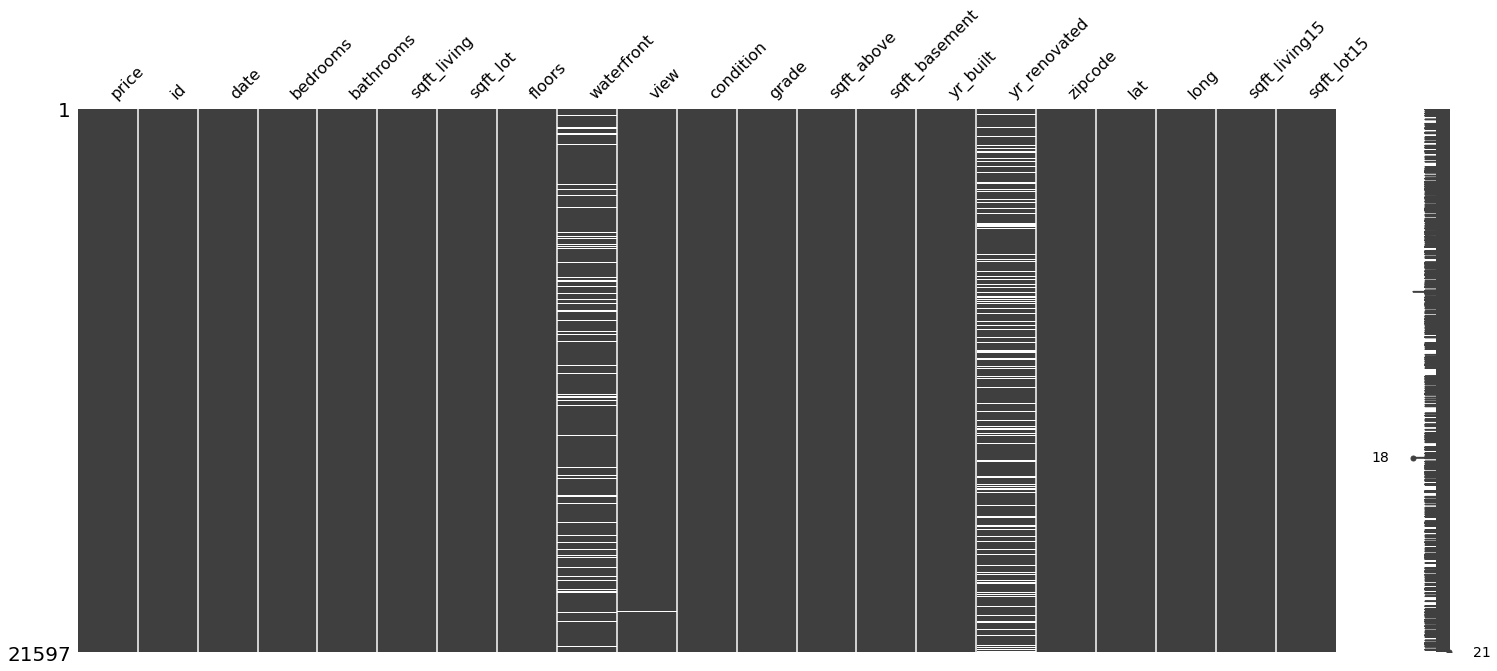

In [10]:
# Use imported missingno package to inspect missing values
msno.matrix(df)

Most missing values seem to come waterfront and yr_renovated columns. 

In [11]:
# Peek at missing data from identified columns
df[['waterfront','yr_renovated']].head()

waterfront  yr_renovated
0         NaN           0.0
1         0.0        1991.0
2         0.0           NaN
3         0.0           0.0
4         0.0           0.0

In [12]:
df.yr_renovated.value_counts(normalize=True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

Lets try to remove 0.0 and observe what the distribution looks like. Based on this, initial result it appears ~96% of rows have not had renovations

In [13]:
df.waterfront.value_counts(normalize=True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

# Feature Data Exploration

## Inspect variables of interest with prices as target

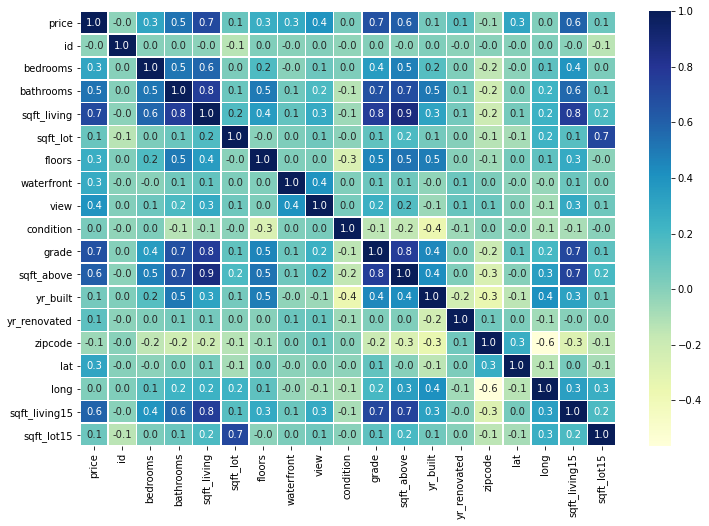

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap( df.corr(), cmap='YlGnBu',linewidths=.5, annot=True,fmt='1.1f', ax=ax );

Based on the above correlation heatmap, it appears price is positively correlated with:
- bathrooms
- bedrooms
- sqft_living
- floors
- waterfront
- view
- grade
- sqft_above (check multi-collinearity with sqft_living)
- sqft_living15 (check multi_collinearity with sqft_living)

Next steps are to inspect these variables and note any interesting observations in respect to price

### Initial Pairplot

In [15]:
select_features = ['price','bathrooms','bedrooms','sqft_living','floors','waterfront',
                   'view','grade','condition']
pos_corr_df = df[select_features]

pos_corr_df.head()

price  bathrooms  bedrooms  sqft_living  floors  waterfront  view  \
0  221900.0       1.00         3         1180     1.0         NaN   0.0   
1  538000.0       2.25         3         2570     2.0         0.0   0.0   
2  180000.0       1.00         2          770     1.0         0.0   0.0   
3  604000.0       3.00         4         1960     1.0         0.0   0.0   
4  510000.0       2.00         3         1680     1.0         0.0   0.0   

   grade  condition  
0      7          3  
1      7          3  
2      6          3  
3      7          5  
4      8          3

While it is expected grade is correlated with price, lets inspect what other aspects of the county dataset can receive high grades

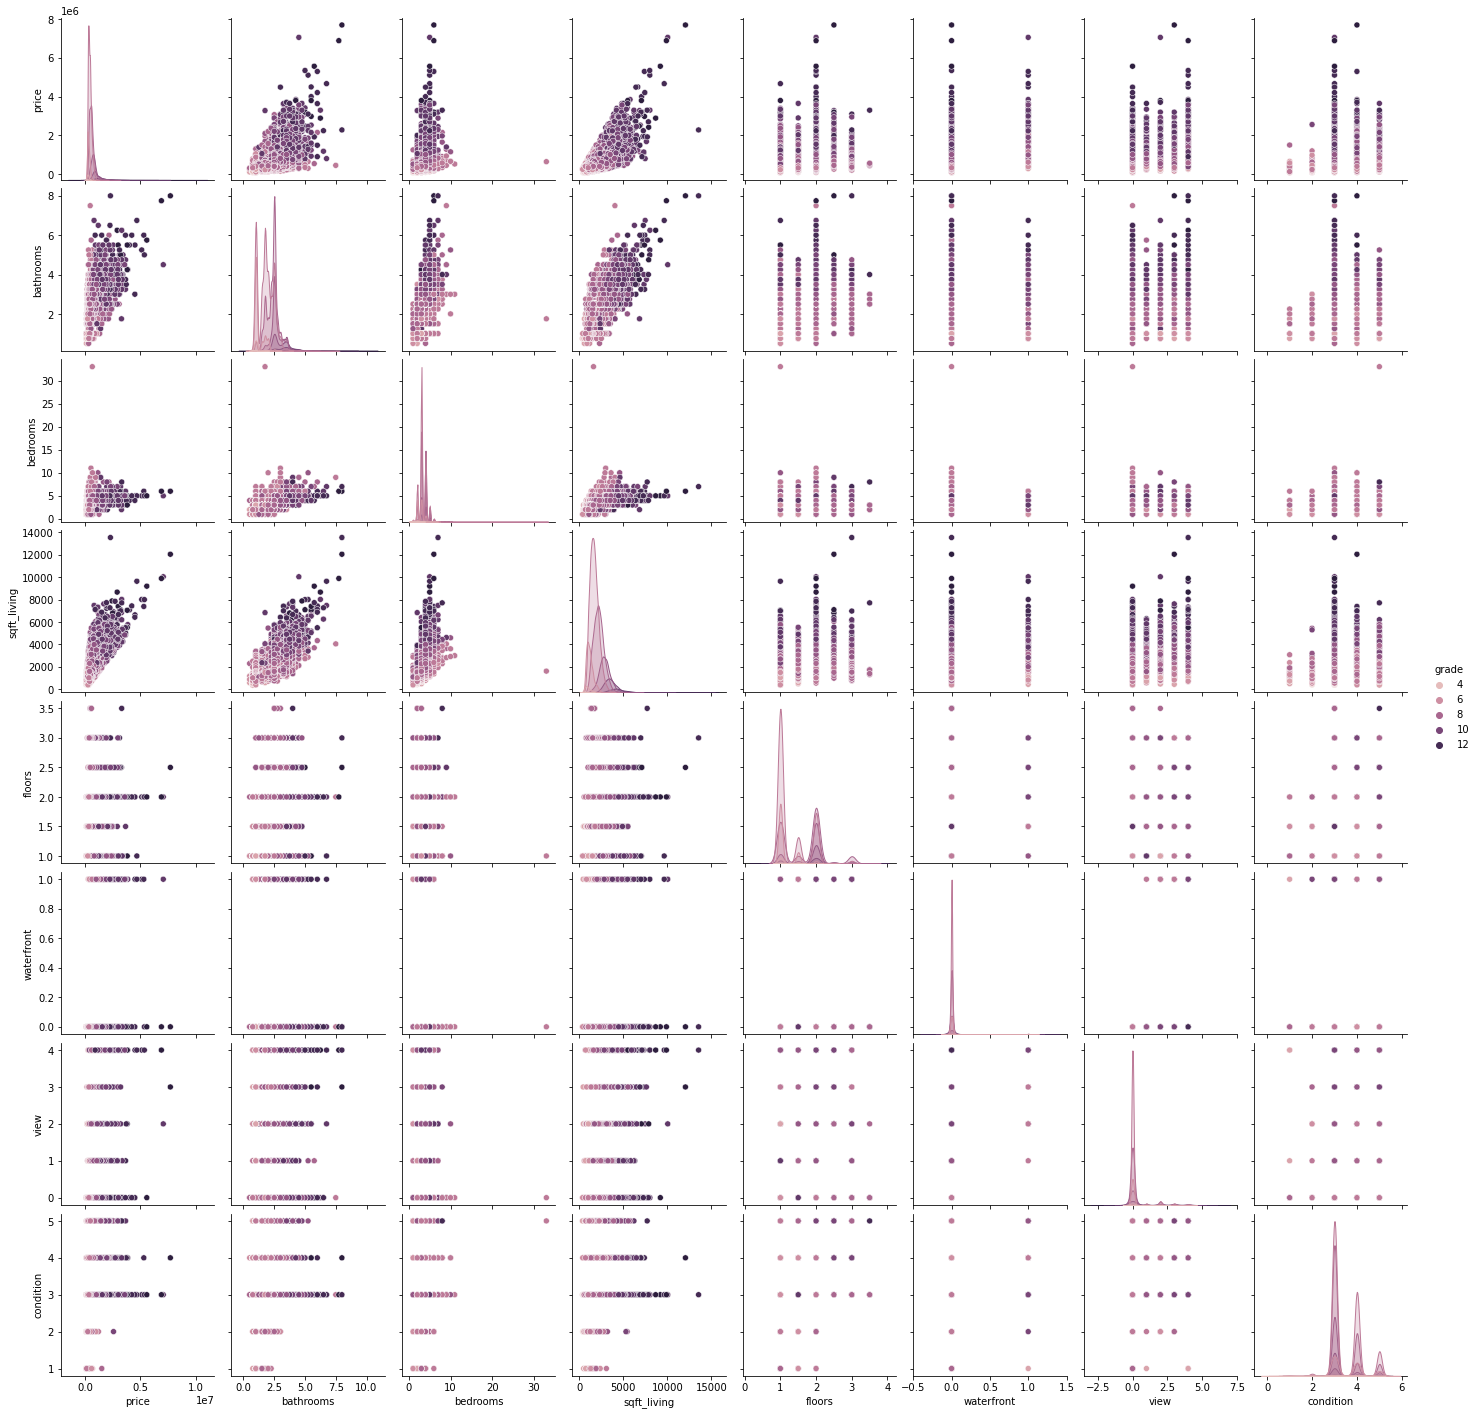

In [16]:
sns.pairplot(pos_corr_df, hue="grade");

### Price and Number of Bedrooms

In [17]:
print(df.bedrooms.unique())

[ 3  2  4  5  1  6  7  8  9 11 10 33]


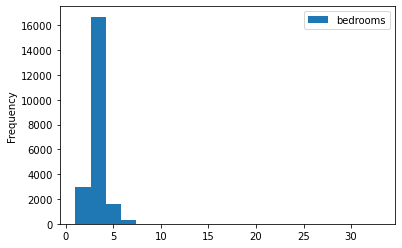

In [18]:
# Check where how many bedrooms the majority of houses have
df[['bedrooms']].plot.hist(bins=20);

Appears most of bedrooms are between 3 and 4.

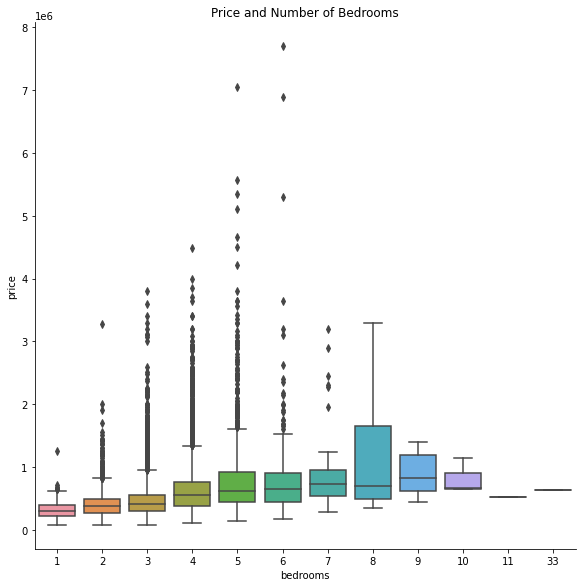

In [19]:
sns.catplot(x='bedrooms',y='price',kind='box',data=df,height=8)
plt.title('Price and Number of Bedrooms');

There is the widest spead of prices for houses with 8 bedrooms. There appears to be large skews and outliers for number of bedrooms between 2-6.

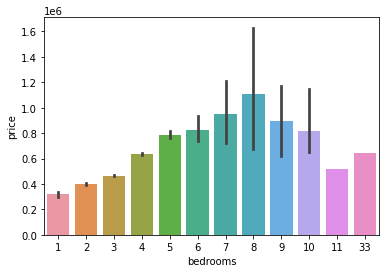

In [20]:
sns.barplot(x='bedrooms',y='price',data=pos_corr_df);

In [21]:
df['yr_built'].value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

## Cells below will focus on examing location data and corresponding census data.
Results from this EDA step will guide how to relate census data to our target of price.

### Read in Census data for 2014 from IPUMS data

In [22]:
census_df = pd.read_csv('data/king_county_demographic_data_2014.csv')
print(census_df.shape)
census_df.head()

(70, 47)


zipcode  median_age_total  median_age_male  median_age_female  \
0    98001              39.5             39.5               39.5   
1    98002              34.4             33.0               36.9   
2    98003              35.6             33.4               38.7   
3    98004              37.9             35.8               40.5   
4    98005              38.0             37.4               39.5   

   total_population  white_alone  black_or_african_american_alone  \
0             31742        22831                             1384   
1             34240        23791                             1994   
2             45632        27246                             4870   
3             31254        21834                              466   
4             17880        10518                              527   

   american_indian_and_alaska_native_alone  asian_alone  \
0                                      337         4016   
1                                     1152         1797   
2                                      470         6309   
3                                       43         7204   
4                                       11         5585   

   native_hawaiian_and_other_pacific_islander_alone  ...  \
0                                               323  ...   
1                                               814  ...   
2                                               964  ...   
3                                                87  ...   
4                                                 0  ...   

   professional_school_degree_25_years_and_over  \
0                                           204   
1                                            67   
2                                           264   
3                                          1222   
4                                           559   

   doctorate_degree_25_years_and_over  total_population_16_years_and_over  \
0                                  93                               25195   
1                                  23                               26009   
2                                 218                               36243   
3                                 674                               26285   
4                                 577                               14789   

   in_labor_force_16_years_and_over  \
0                             17189   
1                             16149   
2                             22864   
3                             17285   
4                              9803   

   in_labor_force_civilian_labor_force_16_years_and_over  \
0                                              17099       
1                                              16097       
2                                              22831       
3                                              17238       
4                                               9803       

   in_labor_force_civilian_labor_force_employed_16_years_and_over  \
0                                              15684                
1                                              14294                
2                                              20794                
3                                              16180                
4                                               8994                

   in_labor_force_civilian_labor_force_unemployed_16_years_and_over  \
0                                               1415                  
1                                               1803                  
2                                               2037                  
3                                               1058                  
4                                                809                  

   in_labor_force_armed_forces_16_years_and_over  \
0                                             90   
1                                             52   
2                                             33   
3                                             4

In [23]:
# Peek at list of columns
list( census_df.columns )

['zipcode',
 'median_age_total',
 'median_age_male',
 'median_age_female',
 'total_population',
 'white_alone',
 'black_or_african_american_alone',
 'american_indian_and_alaska_native_alone',
 'asian_alone',
 'native_hawaiian_and_other_pacific_islander_alone',
 'some_other_race_alone',
 'two_or_more_races',
 'two_or_more_races_two_races_including_some_other_race',
 'two_or_more_races_two_races_excluding_some_other_race,_and_three_or_more_races',
 'total_population_25_years_and_over',
 'no_schooling_completed_25_years_and_over',
 'nursery_school_25_years_and_over',
 'kindergarten_25_years_and_over',
 '1st_grade_25_years_and_over',
 '2nd_grade_25_years_and_over',
 '3rd_grade_25_years_and_over',
 '4th_grade_25_years_and_over',
 '5th_grade_25_years_and_over',
 '6th_grade_25_years_and_over',
 '7th_grade_25_years_and_over',
 '8th_grade_25_years_and_over',
 '9th_grade_25_years_and_over',
 '10th_grade_25_years_and_over',
 '11th_grade_25_years_and_over',
 '12th_grade,_no_diploma_25_years_and_ov

In [24]:
list( df.columns )

['price',
 'id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

### Merge housing and census data

In [25]:
# Select columns of interest to compare with census data
select_columns = ['price','zipcode','date','bedrooms','sqft_living','floors',
                  'waterfront','view','yr_built','grade','lat','long']

# Filter df based on select columns
housing_df = df[select_columns]

# Peek data
housing_df.head()

price  zipcode        date  bedrooms  sqft_living  floors  waterfront  \
0  221900.0    98178  10/13/2014         3         1180     1.0         NaN   
1  538000.0    98125   12/9/2014         3         2570     2.0         0.0   
2  180000.0    98028   2/25/2015         2          770     1.0         0.0   
3  604000.0    98136   12/9/2014         4         1960     1.0         0.0   
4  510000.0    98074   2/18/2015         3         1680     1.0         0.0   

   view  yr_built  grade      lat     long  
0   0.0      1955      7  47.5112 -122.257  
1   0.0      1951      7  47.7210 -122.319  
2   0.0      1933      6  47.7379 -122.233  
3   0.0      1965      7  47.5208 -122.393  
4   0.0      1987      8  47.6168 -122.045

In [26]:
# Convert date to datetime to extrat the year
housing_df['date'] = pd.to_datetime(housing_df['date'])

In [27]:
# Extract the year from date and change the name of the column from date to year
housing_df['date'] = housing_df['date'].map(lambda x: x.year)

# Rename columns
housing_df.rename(columns={'date':'year'},inplace=True)

housing_df.head()

price  zipcode  year  bedrooms  sqft_living  floors  waterfront  view  \
0  221900.0    98178  2014         3         1180     1.0         NaN   0.0   
1  538000.0    98125  2014         3         2570     2.0         0.0   0.0   
2  180000.0    98028  2015         2          770     1.0         0.0   0.0   
3  604000.0    98136  2014         4         1960     1.0         0.0   0.0   
4  510000.0    98074  2015         3         1680     1.0         0.0   0.0   

   yr_built  grade      lat     long  
0      1955      7  47.5112 -122.257  
1      1951      7  47.7210 -122.319  
2      1933      6  47.7379 -122.233  
3      1965      7  47.5208 -122.393  
4      1987      8  47.6168 -122.045

In [28]:
housing_df['year'].value_counts()

2014    14622
2015     6975
Name: year, dtype: int64

In [29]:
# Filter for year 2014 to compare to census data (also filtered to 2014)
housing_df = housing_df[housing_df['year']==2014]

# Peek at data
housing_df.head()

price  zipcode  year  bedrooms  sqft_living  floors  waterfront  view  \
0   221900.0    98178  2014         3         1180     1.0         NaN   0.0   
1   538000.0    98125  2014         3         2570     2.0         0.0   0.0   
3   604000.0    98136  2014         4         1960     1.0         0.0   0.0   
5  1230000.0    98053  2014         4         5420     1.0         0.0   0.0   
6   257500.0    98003  2014         3         1715     2.0         0.0   0.0   

   yr_built  grade      lat     long  
0      1955      7  47.5112 -122.257  
1      1951      7  47.7210 -122.319  
3      1965      7  47.5208 -122.393  
5      2001     11  47.6561 -122.005  
6      1995      7  47.3097 -122.327

In [30]:
# Join the census data & housing data

# Check the length of the dataframes to observe an immediate effects from joining
print(housing_df.shape)
print(census_df.shape)

# Merge data with left join
housing_census_df = pd.merge( housing_df, census_df, on='zipcode', how='left' )

# Peek data
housing_census_df.head()

(14622, 12)
(70, 47)


price  zipcode  year  bedrooms  sqft_living  floors  waterfront  view  \
0   221900.0    98178  2014         3         1180     1.0         NaN   0.0   
1   538000.0    98125  2014         3         2570     2.0         0.0   0.0   
2   604000.0    98136  2014         4         1960     1.0         0.0   0.0   
3  1230000.0    98053  2014         4         5420     1.0         0.0   0.0   
4   257500.0    98003  2014         3         1715     2.0         0.0   0.0   

   yr_built  grade  ...  professional_school_degree_25_years_and_over  \
0      1955      7  ...                                           370   
1      1951      7  ...                                           763   
2      1965      7  ...                                           599   
3      2001     11  ...                                           661   
4      1995      7  ...                                           264   

   doctorate_degree_25_years_and_over  total_population_16_years_and_over  \
0                                 123                               18958   
1                                 945                               31703   
2                                 274                               12776   
3                                 501                               16303   
4                                 218                               36243   

   in_labor_force_16_years_and_over  \
0                             12659   
1                             22009   
2                              9382   
3                             10604   
4                             22864   

   in_labor_force_civilian_labor_force_16_years_and_over  \
0                                              12599       
1                                              21983       
2                                               9319       
3                                              10589       
4                                              22831       

   in_labor_force_civilian_labor_force_employed_16_years_and_over  \
0                                              11630                
1                                              20532                
2                                               8850                
3                                               9985                
4                                              20794                

   in_labor_force_civilian_labor_force_unemployed_16_years_and_over  \
0                                                969                  
1                                               1451                  
2                                                469                  
3                                                604                  
4                                               2037                  

   in_labor_force_armed_forces_16_years_and_over  \
0                                             60   
1                                             26   
2                                             63   
3                                             15   
4                                             33   

   not_in_labor_force_16_years_and_over  median_household_income  
0                                  6299                   7402.0  
1                                  9694                   3109.0  
2                                  3394                  10356.0  
3                                  5699                   9398.0  
4                                 13379                   3263.0  

[5 rows x 58 columns]

## Check for missing values after merging KC Housing Data and Census Data

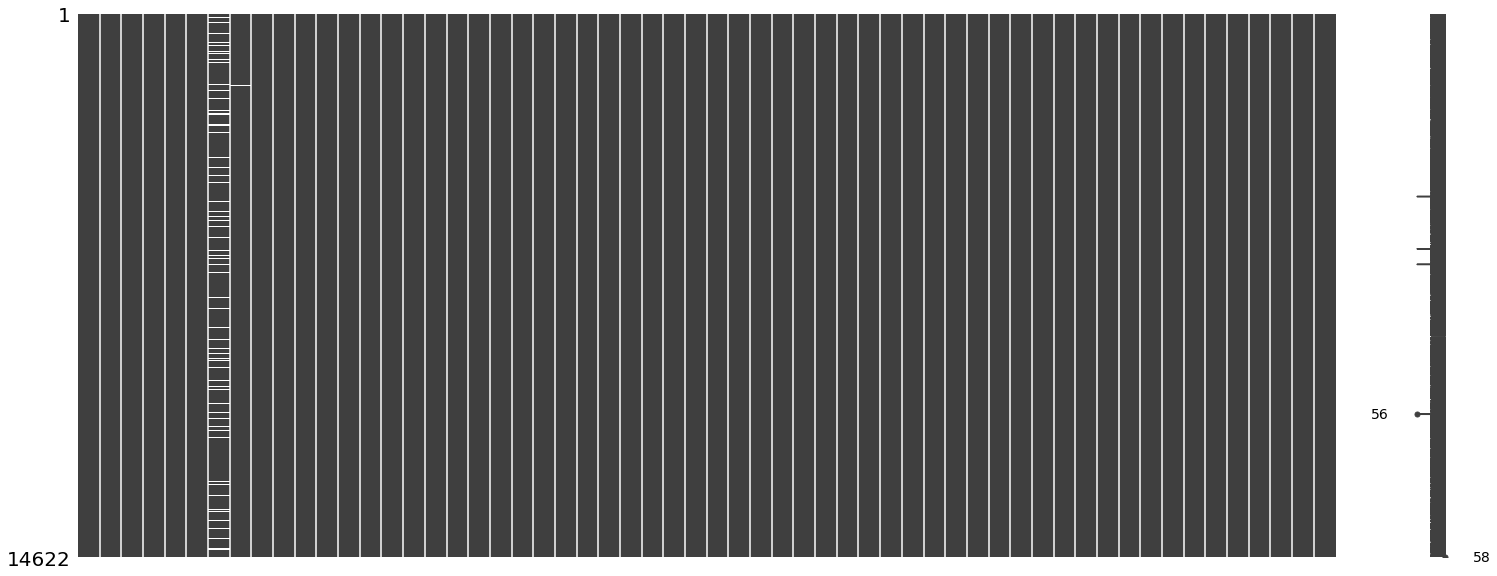

In [31]:
msno.matrix(housing_census_df);

From the above matrix, while the columns are not labeled. The column marked with white stripes is the 7th column. Retrieving the 7th column from housing_census_df, this is the **waterfront** column seen before.

In [32]:
# Observer proportion of missing values for boolean waterfront column
print(housing_census_df.shape)
housing_census_df['waterfront'].value_counts(normalize=True)

(14622, 58)


0.0    0.992095
1.0    0.007905
Name: waterfront, dtype: float64

Based on the overwhelming results of houses without a waterfront, we will fill in those values with 0

In [33]:
# Fill missing values with 0
housing_census_df['waterfront'] = housing_census_df['waterfront'].fillna(0)

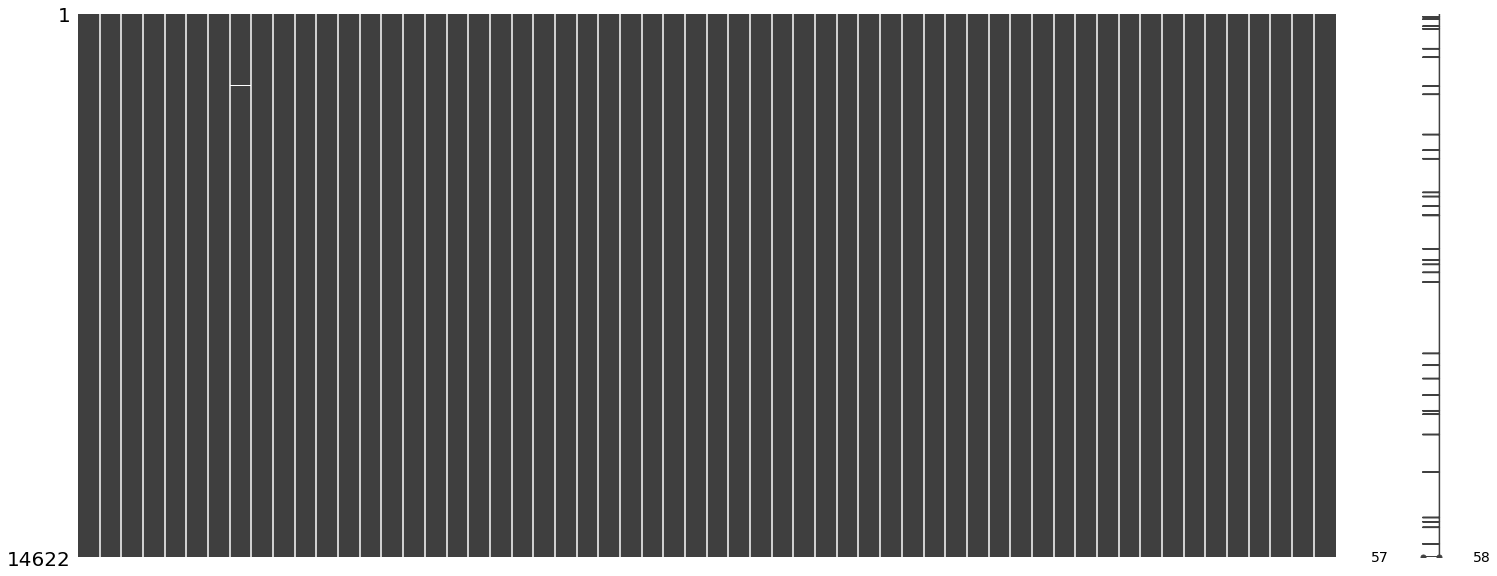

In [34]:
# Check matrix again
msno.matrix(housing_census_df);

In [35]:
list( housing_census_df.columns )

['price',
 'zipcode',
 'year',
 'bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'yr_built',
 'grade',
 'lat',
 'long',
 'median_age_total',
 'median_age_male',
 'median_age_female',
 'total_population',
 'white_alone',
 'black_or_african_american_alone',
 'american_indian_and_alaska_native_alone',
 'asian_alone',
 'native_hawaiian_and_other_pacific_islander_alone',
 'some_other_race_alone',
 'two_or_more_races',
 'two_or_more_races_two_races_including_some_other_race',
 'two_or_more_races_two_races_excluding_some_other_race,_and_three_or_more_races',
 'total_population_25_years_and_over',
 'no_schooling_completed_25_years_and_over',
 'nursery_school_25_years_and_over',
 'kindergarten_25_years_and_over',
 '1st_grade_25_years_and_over',
 '2nd_grade_25_years_and_over',
 '3rd_grade_25_years_and_over',
 '4th_grade_25_years_and_over',
 '5th_grade_25_years_and_over',
 '6th_grade_25_years_and_over',
 '7th_grade_25_years_and_over',
 '8th_grade_25_years_and_over',
 '9th_grade_25_

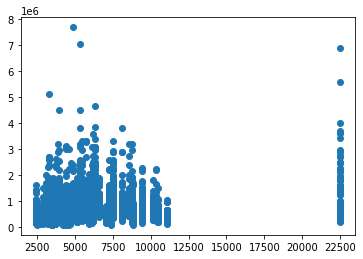

In [36]:
plt.scatter('median_household_income', 'price', data=housing_census_df)

### Visualize map

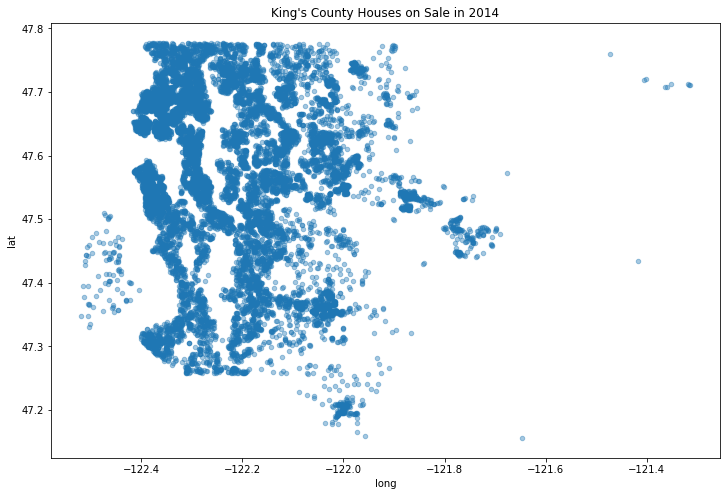

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
housing_census_df.plot( kind='scatter',x='long',y='lat',alpha=0.4, ax=ax )
plt.title("King's County Houses on Sale in 2014");

In [38]:
# Perform log transformation on price column
housing_census_df['log_price'] = np.log(housing_census_df['price'])
housing_census_df['log_total_pop'] = np.log(housing_census_df['total_population'])
housing_census_df['log_income'] = np.log(housing_census_df['median_household_income'])

### Visualize Total Population and Median Household Income Distributions

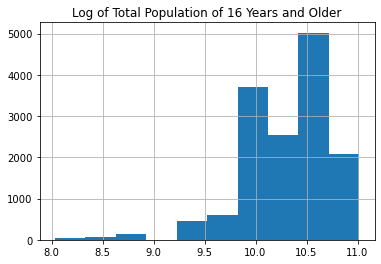

In [39]:
housing_census_df['log_total_pop'].hist()
plt.title('Log of Total Population of 16 Years and Older');

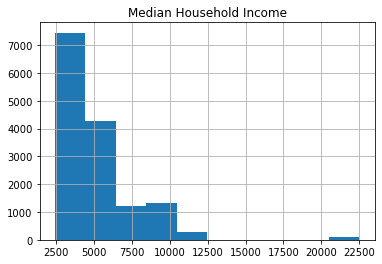

In [40]:
housing_census_df['median_household_income'].hist()
plt.title('Median Household Income');

## Location Exploratory Data Analysis

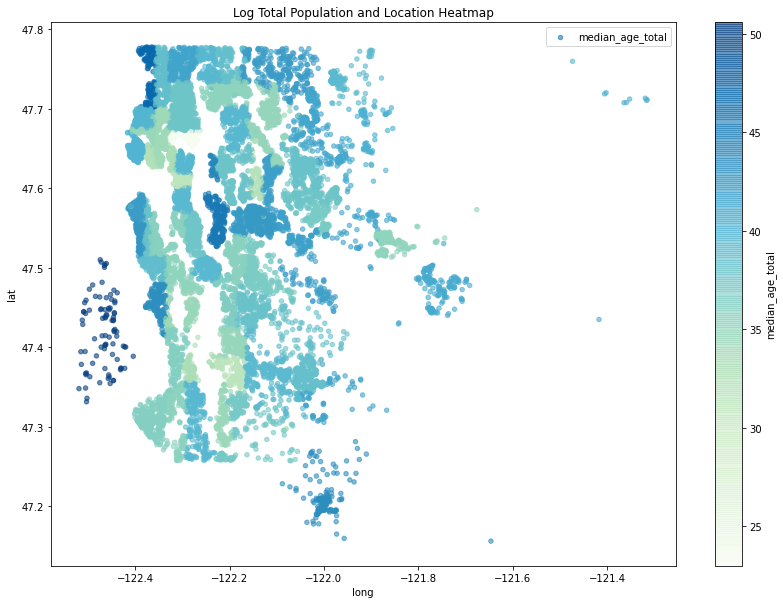

In [41]:
fig, ax = plt.subplots(figsize=(14,10))
housing_census_df.plot(kind="scatter", x="long", y="lat",
    label="median_age_total",
    c='median_age_total', cmap=plt.get_cmap("GnBu"),
    colorbar=True, alpha=0.6, ax=ax)
plt.title('Log Total Population and Location Heatmap')
plt.legend();

### Total Population and Location Map

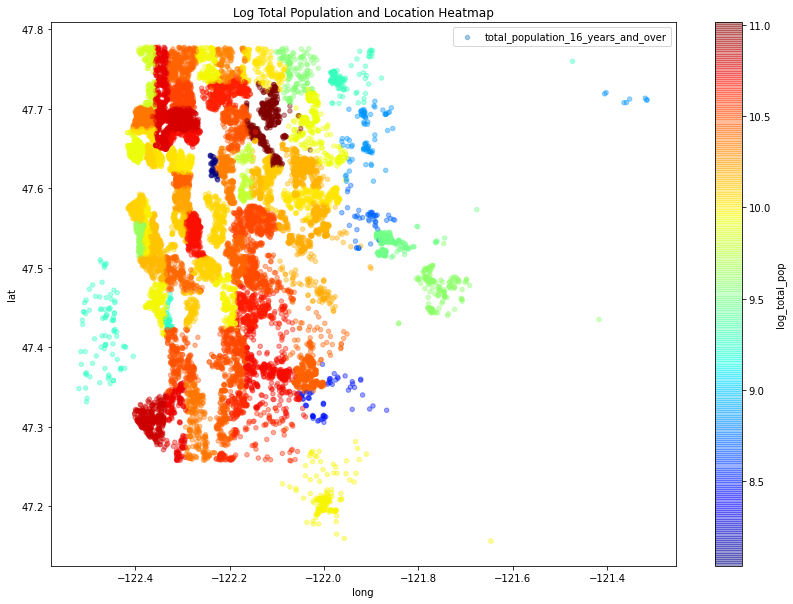

In [42]:
fig, ax = plt.subplots(figsize=(14,10))
housing_census_df.plot(kind="scatter", x="long", y="lat",
    label="total_population_16_years_and_over",
    c='log_total_pop', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, ax=ax)
plt.title('Log Total Population and Location Heatmap')
plt.legend();

### House Price and Location Map

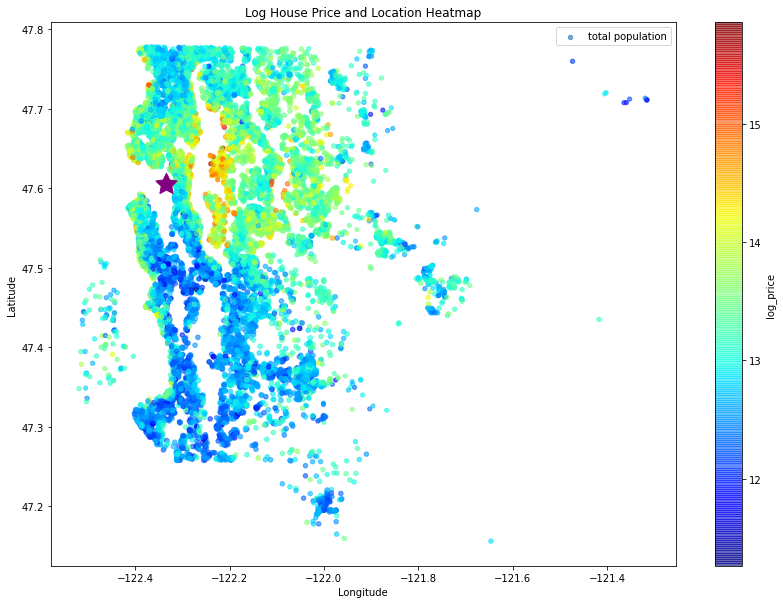

In [45]:
fig, ax = plt.subplots(figsize=(14,10))
housing_census_df.plot(kind="scatter", x="long", y="lat",
    s=housing_census_df['log_total_pop']*2, 
    label="total population",
    c='log_price', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.6, ax=ax)
plt.title('Log House Price and Location Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Plot Downtown Seattle's location
plt.scatter(x=-122.3344,y=47.6050,data=housing_census_df,
            c='purple',
            s=500,
            marker=(5, 1))

# Savefig
plt.savefig('HousePriceandLocationMap_wSeattleMarker.jpg',dpi=300,bbox_inches = 'tight')

### Household Income and House Price Map

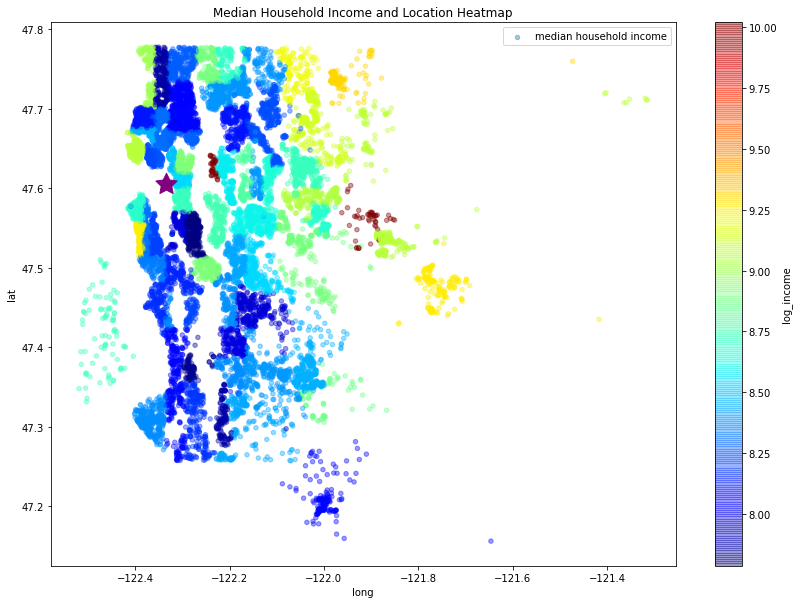

In [46]:
fig, ax = plt.subplots(figsize=(14,10))
housing_census_df.plot(kind="scatter", x="long", y="lat",
#     s=housing_census_df['logprice']*2, 
    label="median household income",
    c='log_income', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, ax=ax
)

# Plot Downtown Seattle's location
plt.scatter(x=-122.3344,y=47.6050,data=housing_census_df,
            c='purple',
            s=500,
            marker=(5, 1))

plt.title('Median Household Income and Location Heatmap')
plt.legend();

## Prep Features for Regression Modeling

### Education Data Transformation and Exploratory Data Analysis

In [47]:
# Select  the education columns of interest
edu_columns = [
 'price',
 'zipcode',
 'regular_high_school_diploma_25_years_and_over',
 'ged_or_alternative_credential_25_years_and_over',
 'some_college,_less_than_1_year_25_years_and_over',
 'some_college,_1_or_more_years,_no_degree_25_years_and_over',
 'associates_degree_25_years_and_over',
 'bachelors_degree_25_years_and_over',
 'masters_degree_25_years_and_over',
 'professional_school_degree_25_years_and_over',
 'doctorate_degree_25_years_and_over']

# Filter housing_census_df for edu_columns
edu_df = housing_census_df[edu_columns]

# Peek at data
edu_df.head()

price  zipcode  regular_high_school_diploma_25_years_and_over  \
0   221900.0    98178                                           3182   
1   538000.0    98125                                           3325   
2   604000.0    98136                                           1414   
3  1230000.0    98053                                           1160   
4   257500.0    98003                                           7405   

   ged_or_alternative_credential_25_years_and_over  \
0                                              785   
1                                              648   
2                                              142   
3                                              119   
4                                             1217   

   some_college,_less_than_1_year_25_years_and_over  \
0                                              1273   
1                                              1600   
2                                               769   
3                                               640   
4                                              2521   

   some_college,_1_or_more_years,_no_degree_25_years_and_over  \
0                                               2582            
1                                               3739            
2                                               1657            
3                                               1978            
4                                               5351            

   associates_degree_25_years_and_over  bachelors_degree_25_years_and_over  \
0                                 1303                                3229   
1                                 2320                                8454   
2                                 1072                                4180   
3                                  880                                5520   
4                                 3031                                4844   

   masters_degree_25_years_and_over  \
0                               837   
1                              3806   
2                              1457   
3                              2964   
4                              1278   

   professional_school_degree_25_years_and_over  \
0                                           370   
1                                           763   
2                                           599   
3                                           661   
4                                           264   

   doctorate_degree_25_years_and_over  
0                                 123  
1                                 945  
2                                 274  
3                                 501  
4                                 218

In [48]:
# Transform the education levels from columns to get into a row format for further analysis
edu_value_vars = list(edu_df.columns)[2:]

# Use pd.melt to get the column education levels into row format
edu_zipcode_df = edu_df.melt(id_vars=['zipcode'], value_vars=edu_value_vars)

print(edu_zipcode_df.shape)

edu_zipcode_df.head()

(131598, 3)


zipcode                                       variable  value
0    98178  regular_high_school_diploma_25_years_and_over   3182
1    98125  regular_high_school_diploma_25_years_and_over   3325
2    98136  regular_high_school_diploma_25_years_and_over   1414
3    98053  regular_high_school_diploma_25_years_and_over   1160
4    98003  regular_high_school_diploma_25_years_and_over   7405

In [49]:
# There appears to be duplicated rows from the pd.melt transformation -- lets check for duplication and dedupe

print(edu_zipcode_df.duplicated().any())

True


In [50]:
# Drop duplicates
edu_zipcode_df.drop_duplicates(inplace=True)

# Check shape of dataframe after droppping dupes
print(edu_zipcode_df.shape)

(630, 3)


After removing duplicates, we significantly reduced the size of our dataframe from 131,598 rows to 630 rows!

In [51]:
list( housing_census_df.columns )

['price',
 'zipcode',
 'year',
 'bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'yr_built',
 'grade',
 'lat',
 'long',
 'median_age_total',
 'median_age_male',
 'median_age_female',
 'total_population',
 'white_alone',
 'black_or_african_american_alone',
 'american_indian_and_alaska_native_alone',
 'asian_alone',
 'native_hawaiian_and_other_pacific_islander_alone',
 'some_other_race_alone',
 'two_or_more_races',
 'two_or_more_races_two_races_including_some_other_race',
 'two_or_more_races_two_races_excluding_some_other_race,_and_three_or_more_races',
 'total_population_25_years_and_over',
 'no_schooling_completed_25_years_and_over',
 'nursery_school_25_years_and_over',
 'kindergarten_25_years_and_over',
 '1st_grade_25_years_and_over',
 '2nd_grade_25_years_and_over',
 '3rd_grade_25_years_and_over',
 '4th_grade_25_years_and_over',
 '5th_grade_25_years_and_over',
 '6th_grade_25_years_and_over',
 '7th_grade_25_years_and_over',
 '8th_grade_25_years_and_over',
 '9th_grade_25_

In [52]:
zipcode_price_df = pd.DataFrame( housing_census_df.groupby('zipcode')['price'].median() ).reset_index()
zipcode_price_df.rename(columns={'price':'median_price'},inplace=True)
zipcode_price_df.head()

zipcode  median_price
0    98001      254950.0
1    98002      234500.0
2    98003      262000.0
3    98004     1080000.0
4    98005      754000.0

In [53]:
# Merge edu_zipcode_df back with edu_df to get price

edu_zipcode_df = pd.merge( edu_zipcode_df, zipcode_price_df, on='zipcode', how='inner' )

edu_zipcode_df.rename(columns={'variable':'education_level','value':'population'},inplace=True)

edu_zipcode_df.head()

zipcode                                    education_level  population  \
0    98178      regular_high_school_diploma_25_years_and_over        3182   
1    98178    ged_or_alternative_credential_25_years_and_over         785   
2    98178   some_college,_less_than_1_year_25_years_and_over        1273   
3    98178  some_college,_1_or_more_years,_no_degree_25_ye...        2582   
4    98178                associates_degree_25_years_and_over        1303   

   median_price  
0      279000.0  
1      279000.0  
2      279000.0  
3      279000.0  
4      279000.0

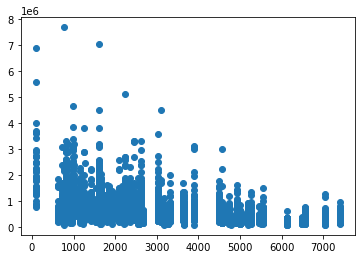

In [54]:
plt.scatter( 'regular_high_school_diploma_25_years_and_over','price',data=housing_census_df )

In [55]:
edu_zipcode_df.shape

(630, 4)

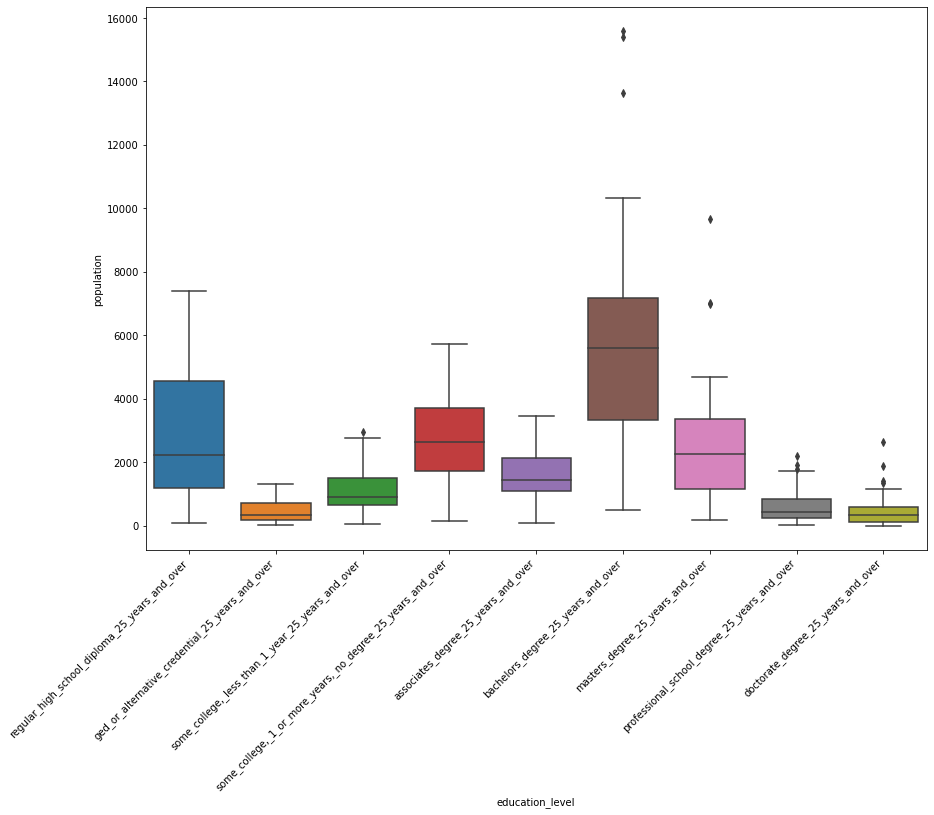

In [56]:
fig, ax = plt.subplots(figsize=(14,10))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(x='education_level', y='population', data=edu_zipcode_df, ax=ax)
plt.title('');

### Distance from downtown feature

Some intuition would be that the closer houses are to downtown seattle, the more expensive housing prices can get. Let's engineer a feature to calculate the distance from the house to downtown Seattle lat lon coordinates.

In [57]:
# Set up lat - long tuple
housing_census_df['lat_long'] = list(zip(housing_census_df.lat, housing_census_df.long))

housing_census_df[['lat_long']].head()

lat_long
0             (47.5112, -122.257)
1  (47.721000000000004, -122.319)
2  (47.5208, -122.39299999999999)
3             (47.6561, -122.005)
4  (47.3097, -122.32700000000001)

In [58]:
# Calculate the distance for each house to the coordinates of downtown Seattle
downtown_seattle = (47.6050, -122.3344)

housing_census_df['distance_from_downtown_km'] = housing_census_df['lat_long'].apply(lambda x: hs.haversine(downtown_seattle,x))

housing_census_df[['lat_long','distance_from_downtown_km']].head()

lat_long  distance_from_downtown_km
0             (47.5112, -122.257)                  11.938179
1  (47.721000000000004, -122.319)                  12.950085
2  (47.5208, -122.39299999999999)                  10.343664
3             (47.6561, -122.005)                  25.329222
4  (47.3097, -122.32700000000001)                  32.840620

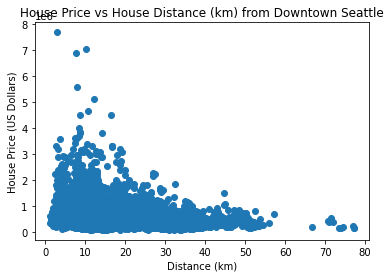

In [59]:
# Examine how distance from downtown correlates with price
plt.scatter('distance_from_downtown_km', 'price', data = housing_census_df)
plt.title("House Price vs House Distance (km) from Downtown Seattle")
plt.xlabel("Distance (km)")
plt.ylabel("House Price (US Dollars)");

We can observe for the range between 5km and 20km there are houses with higher house prices, however at the same time there are houses close to 0km where the houses within the 100k US dollars range.

There doesn't seem to be any linear relationship with a houses distance from downtown and price.

# Model Building

## Simple Model

In [61]:
pd.DataFrame(housing_census_df.view.value_counts(normalize=True))

view
0.0  0.902865
2.0  0.043323
3.0  0.023992
1.0  0.014944
4.0  0.014875

In [62]:
housing_census_df.shape

(14622, 63)

In [63]:
housing_census_df.view.value_counts(normalize=True)

0.0    0.902865
2.0    0.043323
3.0    0.023992
1.0    0.014944
4.0    0.014875
Name: view, dtype: float64

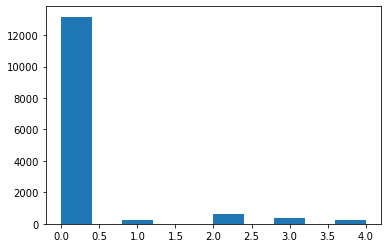

In [64]:
plt.hist('view',data=housing_census_df);

In [65]:
# Prep potential features of interest
sqft_living = housing_census_df['sqft_living']
dist_downtown = housing_census_df['distance_from_downtown_km']
view = housing_census_df['view']

scaled_sqft_living = (sqft_living-min(sqft_living))/(max(sqft_living)-min(sqft_living))
scaled_dist_downtown = (dist_downtown-min(dist_downtown))/(max(dist_downtown)-min(dist_downtown))

# Categorical cols
bed_dummies = pd.get_dummies(housing_census_df['bedrooms'], prefix='bed', drop_first=True)
age_dummies = pd.get_dummies(housing_census_df['median_age_total'], prefix='age', drop_first=True)
year_built_dummies = pd.get_dummies(housing_census_df['yr_built'], prefix='yr_built', drop_first=True)

In [66]:
# Label Encode binary cat

label_encoder = LabelEncoder()
waterfront_labels = label_encoder.fit_transform(housing_census_df['waterfront'])
waterfront_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
# Simple Model - Feature Experimentation
housing_fin_df = pd.DataFrame([])

housing_fin_df['dist_downtown'] = dist_downtown
housing_fin_df['waterfront'] = waterfront_labels

price = housing_census_df['price']
age = housing_census_df['median_age_total']
grade = housing_census_df['grade']

housing_fin_df = pd.concat([price, age, housing_fin_df], axis=1)

In [68]:
outcome = 'price'
predictors = housing_fin_df.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [69]:
simple_model = ols(formula=formula, data=housing_fin_df).fit()
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     948.0
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        22:38:07   Log-Likelihood:            -2.0690e+05
No. Observations:               14622   AIC:                         4.138e+05
Df Residuals:                   14618   BIC:                         4.138e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.362e+05   2.99e+04      7.909      0.000    1.78e+05    2.95e+05
median_age_total  1.261e+04    786.358     16.041      0.000    1.11e+04    1.42e+04
dist_downtown    -1.011e+04    266.329    -37.953      0.000   -1.06e+04   -9586.033
waterfront        1.136e+06   3.35e+04     33.879      0.000    1.07e+06     1.2e+06
==============================================================================
Omnibus:                    12821.247   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1003978.986
Skew:                           3.848   Prob(JB):                         0.00
Kurtosis:                      42.858   Cond. No.                         517.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Linearity 

In [70]:
rainbow_statistic, rainbow_p_value = linear_rainbow(simple_model)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0784466157802752
Rainbow p-value: 0.0006237987209637256


Based on the p-value being less than our 0.05 threshold, we can state that our current simple model is violating the linearity assumption of linear regression.

## Normality

<Figure size 864x576 with 0 Axes>

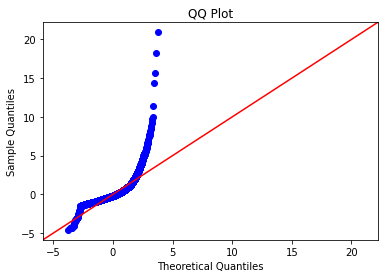

In [71]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(simple_model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

Given the s-shaped QQ plot, we are observing heavy right skews, hence we are not meeting the normality assumptions in our simple model.

## Homoscadasticity

In [72]:
y = housing_fin_df['price']
y_hat = simple_model.predict()

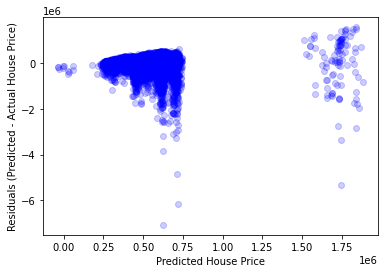

In [73]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel="Predicted House Price",
        ylabel="Residuals (Predicted - Actual House Price)")
ax2.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

## Simple Model Evaluation

Based on the plot above, it also appears that the simple model is not meeting the homoscadasticity assumption either. We will need to do further investigation, and transformations so we can set up a more suitable model.

Let us aim to observe the distribution of Median Household Income and House Prices to see if we can remove outliers.

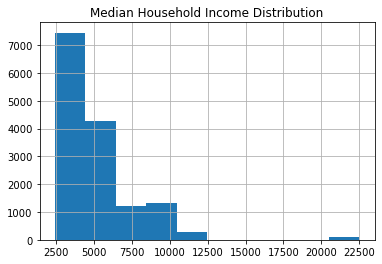

In [74]:
housing_census_df.median_household_income.hist()
plt.title('Median Household Income Distribution');

# Savefig
plt.savefig('MedianHouseholdIncomeDist_woOutliers.jpg',dpi=300,bbox_inches = 'tight')

The median household income distribution appears strongly right-skewed with apparent outliers. Lets aim to remove them.

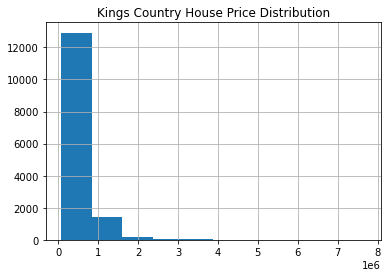

In [75]:
housing_census_df.price.hist()
plt.title('Kings Country House Price Distribution');

# Savefig
plt.savefig('HousePriceDist_woOutliers.jpg',dpi=300,bbox_inches = 'tight')

There appears a strong right skew with the Kings County house prices. Removing these may help with the issues we saw with the initial linear regression assumption checks.

## Outlier Removal

In [76]:
housing_census_df.head()

price  zipcode  year  bedrooms  sqft_living  floors  waterfront  view  \
0   221900.0    98178  2014         3         1180     1.0         0.0   0.0   
1   538000.0    98125  2014         3         2570     2.0         0.0   0.0   
2   604000.0    98136  2014         4         1960     1.0         0.0   0.0   
3  1230000.0    98053  2014         4         5420     1.0         0.0   0.0   
4   257500.0    98003  2014         3         1715     2.0         0.0   0.0   

   yr_built  grade  ...  \
0      1955      7  ...   
1      1951      7  ...   
2      1965      7  ...   
3      2001     11  ...   
4      1995      7  ...   

   in_labor_force_civilian_labor_force_employed_16_years_and_over  \
0                                              11630                
1                                              20532                
2                                               8850                
3                                               9985                
4                                              20794                

   in_labor_force_civilian_labor_force_unemployed_16_years_and_over  \
0                                                969                  
1                                               1451                  
2                                                469                  
3                                                604                  
4                                               2037                  

   in_labor_force_armed_forces_16_years_and_over  \
0                                             60   
1                                             26   
2                                             63   
3                                             15   
4                                             33   

   not_in_labor_force_16_years_and_over  median_household_income  log_price  \
0                                  6299                   7402.0  12.309982   
1                                  9694                   3109.0  13.195614   
2                                  3394                  10356.0  13.311329   
3                                  5699                   9398.0  14.022525   
4                                 13379                   3263.0  12.458775   

   log_total_pop  log_income                        lat_long  \
0      10.080210    8.909506             (47.5112, -122.257)   
1      10.533695    8.042056  (47.721000000000004, -122.319)   
2       9.635739    9.245321  (47.5208, -122.39299999999999)   
3       9.939771    9.148252             (47.6561, -122.005)   
4      10.728365    8.090402  (47.3097, -122.32700000000001)   

   distance_from_downtown_km  
0                  11.938179  
1                  12.950085  
2                  10.343664  
3                  25.329222  
4                  32.840620  

[5 rows x 63 columns]

In [77]:
# Check unique median household income, joining this data from census with kings county will introduce duplicates
len( housing_census_df.median_household_income.unique() )

70

Since we joined the census data with median values per zip code, perhaps it is best to treat these values at categorical

In [78]:
# Remove outliers based on median_household_income column
housing_census_df_o = housing_census_df[(np.abs(stats.zscore(housing_census_df['median_household_income'])) < 2)]

# Remove outliers based on price
housing_census_df_o = housing_census_df_o[(np.abs(stats.zscore(housing_census_df_o['price'])) < 2)]

housing_census_df_o.head()

price  zipcode  year  bedrooms  sqft_living  floors  waterfront  view  \
0   221900.0    98178  2014         3         1180     1.0         0.0   0.0   
1   538000.0    98125  2014         3         2570     2.0         0.0   0.0   
3  1230000.0    98053  2014         4         5420     1.0         0.0   0.0   
4   257500.0    98003  2014         3         1715     2.0         0.0   0.0   
5   468000.0    98115  2014         2         1160     1.0         0.0   0.0   

   yr_built  grade  ...  \
0      1955      7  ...   
1      1951      7  ...   
3      2001     11  ...   
4      1995      7  ...   
5      1942      7  ...   

   in_labor_force_civilian_labor_force_employed_16_years_and_over  \
0                                              11630                
1                                              20532                
3                                               9985                
4                                              20794                
5                                              28193                

   in_labor_force_civilian_labor_force_unemployed_16_years_and_over  \
0                                                969                  
1                                               1451                  
3                                                604                  
4                                               2037                  
5                                               1556                  

   in_labor_force_armed_forces_16_years_and_over  \
0                                             60   
1                                             26   
3                                             15   
4                                             33   
5                                             39   

   not_in_labor_force_16_years_and_over  median_household_income  log_price  \
0                                  6299                   7402.0  12.309982   
1                                  9694                   3109.0  13.195614   
3                                  5699                   9398.0  14.022525   
4                                 13379                   3263.0  12.458775   
5                                 10398                   3219.0  13.056224   

   log_total_pop  log_income                        lat_long  \
0      10.080210    8.909506             (47.5112, -122.257)   
1      10.533695    8.042056  (47.721000000000004, -122.319)   
3       9.939771    9.148252             (47.6561, -122.005)   
4      10.728365    8.090402  (47.3097, -122.32700000000001)   
5      10.790514    8.076826               (47.69, -122.292)   

   distance_from_downtown_km  
0                  11.938179  
1                  12.950085  
3                  25.329222  
4                  32.840620  
5                   9.970998  

[5 rows x 63 columns]

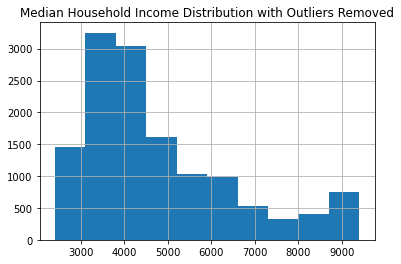

In [79]:
housing_census_df_o.median_household_income.hist()
plt.title('Median Household Income Distribution with Outliers Removed');

# Savefig
plt.savefig('MedianHouseholdIncomeDist_woOutliers.jpg',dpi=300,bbox_inches = 'tight')

Removing the outliers in the median household income show a slight bimodal peak. Even with removing the outliers with a z-score higher than 2, the distribution of median household income still appears right-skewed.

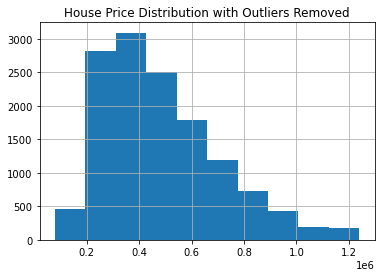

In [80]:
housing_census_df_o.price.hist()
plt.title('House Price Distribution with Outliers Removed');

# Savefig
plt.savefig('HousePriceDist_wOutliers.jpg',dpi=300,bbox_inches = 'tight')

Removing the outliers in the house prices bring the range of the house prices to a more normal distribution, however there is still an observable right skew.

### Set up income and total population categories

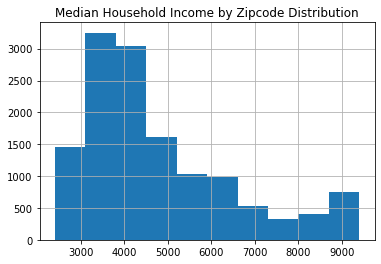

In [81]:
housing_census_df_o.median_household_income.hist()
plt.title('Median Household Income by Zipcode Distribution');

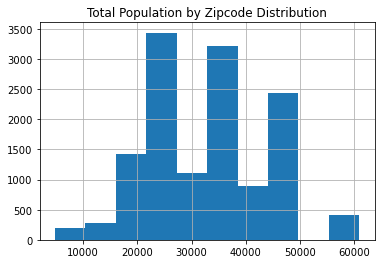

In [82]:
housing_census_df_o.total_population.hist()
plt.title('Total Population by Zipcode Distribution');

In [83]:
# Create income category column
housing_census_df_o['income_cat'] = pd.cut(housing_census_df_o.median_household_income, 
                                           3, labels=['Low', 'Medium', 'High'])
housing_census_df_o['total_population_cat'] = pd.cut(housing_census_df_o.total_population, 
                                                 4, labels=['Low', 'Low_Medium', 'High_Medium', 'High'])

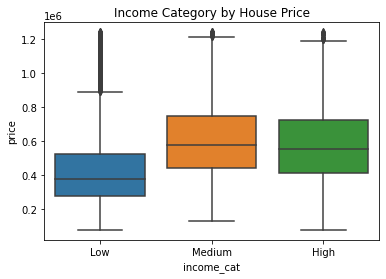

In [84]:
sns.boxplot( 'income_cat', 'price', data=housing_census_df_o )
plt.title('Income Category by House Price');

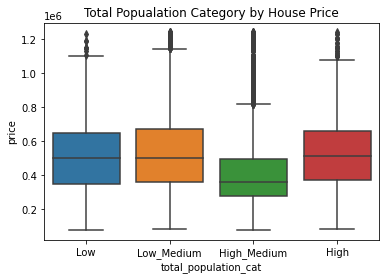

In [85]:
sns.boxplot( 'total_population_cat', 'price', data=housing_census_df_o )
plt.title('Total Popualation Category by House Price');

### Set up age column

In [86]:
housing_census_df_o.median_age_total.unique()

array([39.4, 37.8, 41.3, 35.6, 39.6, 38.2, 34. , 34.4, 38.7, 37.2, 31.5,
       32.5, 39.7, 41.8, 39.9, 38.1, 34.9, 34.5, 35.7, 43.4, 32.1, 34.2,
       23. , 39.2, 41.9, 31.4, 37.9, 39.5, 38. , 38.5, 37.7, 36.1, 45.5,
       33.3, 36.2, 35.5, 37. , 42.5, 33.9, 33.1, 43.5, 36.9, 38.8, 41.5,
       47.1, 38.6, 35.8, 50.6, 34.7, 40.1, 42.1, 35.2, 40.4, 36.5, 41.6])

Let round median age values for better interpretability

In [87]:
housing_census_df_o['median_age_total'] = housing_census_df_o['median_age_total'].map(lambda x: int( round(x,0) ) )

## Model A

Let's create a new model now that the outliers are removed and see if we can get a better sense of what the coefficients look like when throwing a few features into the model.

In [88]:
# Numerical cols
sqft_living = housing_census_df_o['sqft_living']
dist_downtown = housing_census_df_o['distance_from_downtown_km']
view = housing_census_df_o['view']

scaled_sqft_living = (sqft_living-min(sqft_living))/(max(sqft_living)-min(sqft_living))
scaled_dist_downtown = (dist_downtown-min(dist_downtown))/(max(dist_downtown)-min(dist_downtown))

# Categorical cols
bed_dummies = pd.get_dummies(housing_census_df_o['bedrooms'], prefix='bed', drop_first=True)
income_dummies = pd.get_dummies(housing_census_df_o['income_cat'], prefix='income', drop_first=True)
age_dummies = pd.get_dummies(housing_census_df_o['median_age_total'], prefix='age', drop_first=True)
population_dummies = pd.get_dummies(housing_census_df_o['total_population_cat'], prefix='pop', drop_first=True)
year_built_dummies = pd.get_dummies(housing_census_df_o['yr_built'], prefix='yr_built', drop_first=True)

In [89]:
# Label Encode binary cat

label_encoder = LabelEncoder()
waterfront_labels = label_encoder.fit_transform(housing_census_df_o['waterfront'])
waterfront_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
# Model A - Feature Experimentation
housing_fin_df = pd.DataFrame([])

housing_fin_df['dist_downtown'] = dist_downtown
housing_fin_df['waterfront'] = waterfront_labels

price = housing_census_df_o['price']
age = housing_census_df_o['median_age_total']
grade = housing_census_df_o['grade']

housing_fin_df = pd.concat([price, age, housing_fin_df], axis=1)

In [91]:
outcome = 'price'
predictors = housing_fin_df.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [92]:
modelA = ols(formula=formula, data=housing_fin_df).fit()
modelA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     566.6
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        22:38:21   Log-Likelihood:            -1.8300e+05
No. Observations:               13385   AIC:                         3.660e+05
Df Residuals:                   13381   BIC:                         3.660e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.218e+05   1.96e+04     16.431      0.000    2.83e+05     3.6e+05
median_age_total  7617.8143    517.093     14.732      0.000    6604.238    8631.390
dist_downtown    -6954.6506    178.650    -38.929      0.000   -7304.831   -6604.471
waterfront        2.474e+05   3.11e+04      7.956      0.000    1.86e+05    3.08e+05
==============================================================================
Omnibus:                     1472.043   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2015.247
Skew:                           0.894   Prob(JB):                         0.00
Kurtosis:                       3.648   Cond. No.                         731.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model A Evaluation

In these models we are evaluating how location affects house prices. In this regard we're examining dist_downtown, and waterfront features as potential influencers for house prices. Moreover, along with the house's location we want to evaluate how much a person's age influence a house's price. However, according to our three features, collectively they explain only 11% of the variance in house prices.

According to our model:
- A house without regard to age, a distance to downtown, or having a waterfront is expected to have a house price of 321,800 US dollars.
- For an increase in year of age, we expect house to increase roughly 7,617 US dollars
- For an additional km in the distance from downtown, we expect the house price to decrease by 6,954 US dollars
- Having a waterfront increases the house price by 247,400 US dollars

Checking assumptions of linear regression.

### Linearity

In [93]:
rainbow_statistic, rainbow_p_value = linear_rainbow(modelA)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0670002969988437
Rainbow p-value: 0.004001726281829162


Based on the rainbow p-value being below our 0.05 threshold, returning a lower p-value means that the current model does violate the linearity assumption.

### Normality

<Figure size 864x576 with 0 Axes>

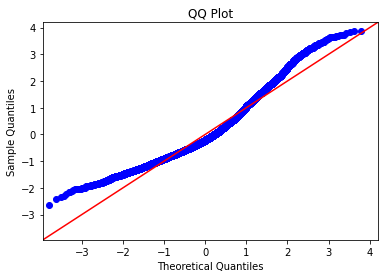

In [94]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(modelA.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

Based on the above QQ plot, assessing it qualitatively we can say that the residuals are roughly normal. Hence, we can say that perhaps the model does not violate the normality assumption. Nonetheless, this is subjective to how we assess the QQ plot.

### Homoscadasticity

In [95]:
y = housing_fin_df['price']
y_hat = modelA.predict()

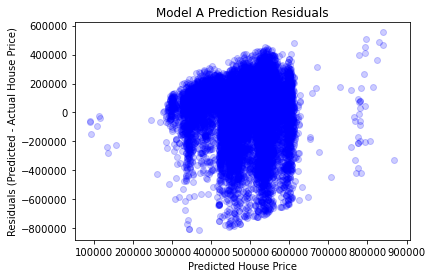

In [96]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel="Predicted House Price",
        ylabel="Residuals (Predicted - Actual House Price)")
ax2.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2)

plt.title('Model A Prediction Residuals')

# Savefig
plt.savefig('ModelA_Residuals.jpg',dpi=300,bbox_inches = 'tight')

Based on visually inspecting the plot above, it appears for house prices we are predicting between 300k and 600k, we are largely over and under predicting.

It could be worth inspecting what characteristics we can tease out and examine for houses within this house range.

In [97]:
# Set up housing_mid_range dataframe to examine
housing_mid_range = housing_census_df_o[ (housing_census_df_o['price'] <= 600000) & (housing_census_df_o['price'] >= 300000)]

In [98]:
# Create list of dataframes to iterate through and plot
df_list = [ ('Raw Kings County Housing + Census Data',housing_census_df), 
            ('Without Outliers Kings County Housing + Census Data',housing_census_df_o), 
            ( 'Mid Range House Price Kings County + Census Data' ,housing_mid_range) ]

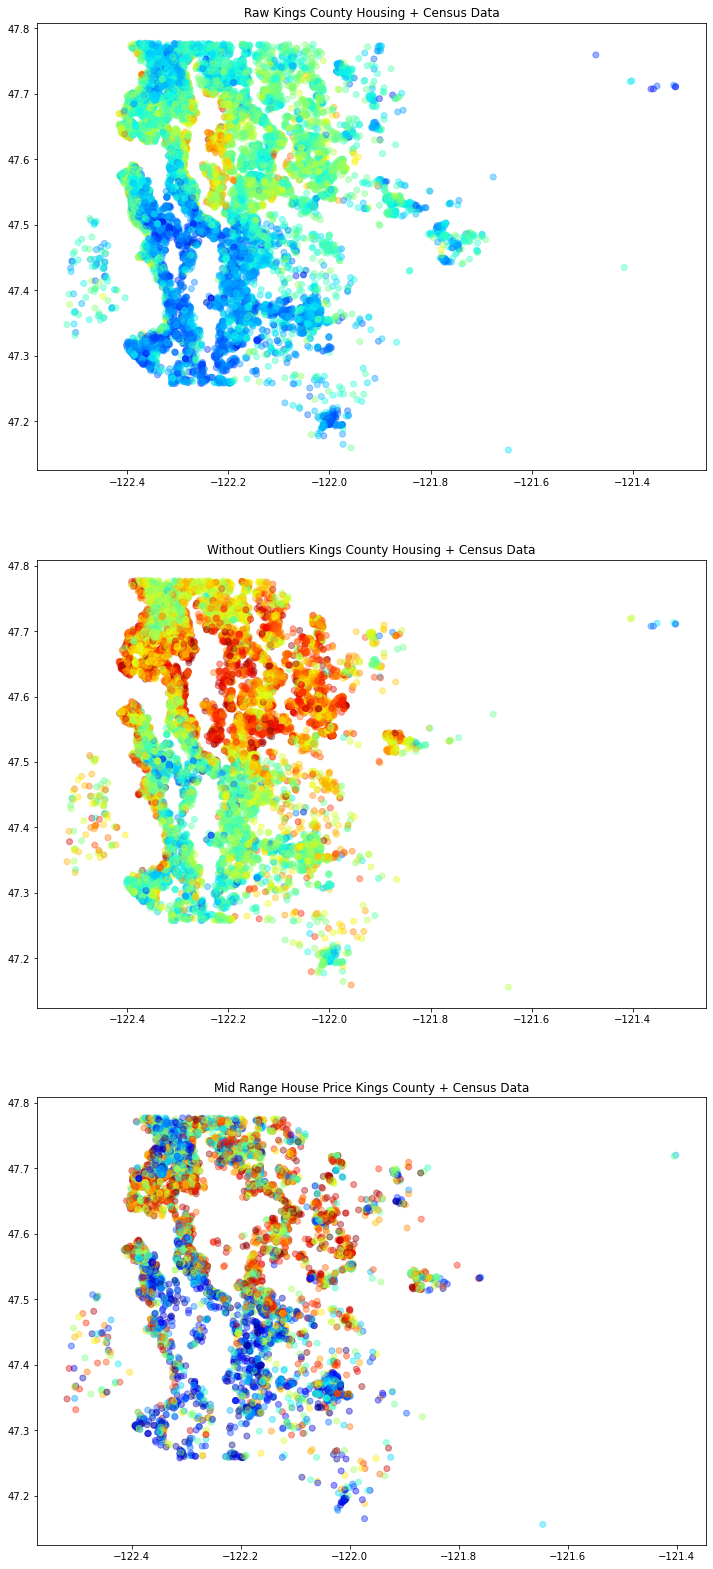

In [99]:
fig, axes = plt.subplots(3, 1, figsize=(12, 28))

for df, ax in zip(df_list, axes.flatten()):
    plot_title = df[0]
    data = df[1]
    x = data['long']
    y = data['lat']
    c = data['log_price']
    colormap = plt.get_cmap('jet')
    
    ax.scatter(x, y, c=c, alpha=0.4, cmap=colormap)
    ax.set_title(plot_title)

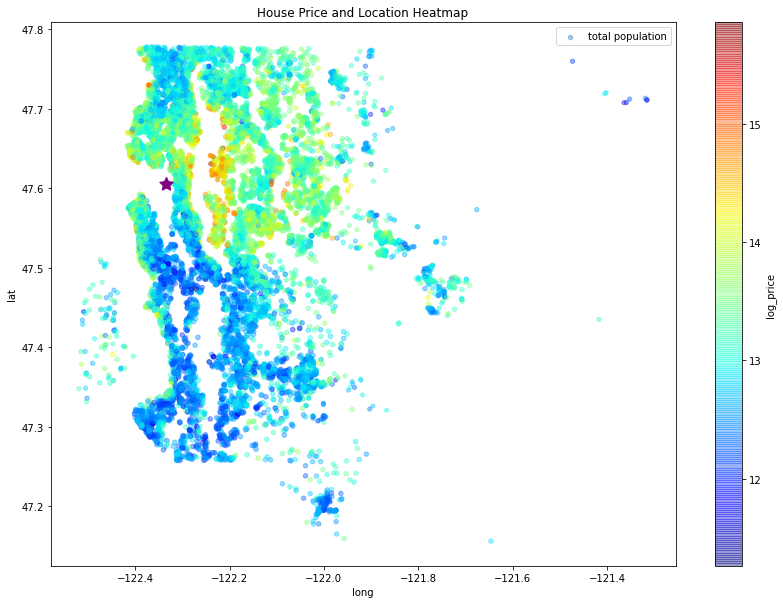

In [100]:
fig, ax = plt.subplots(figsize=(14,10))
# Loop over list of ax variables <-- plot on each of them
housing_census_df.plot(kind="scatter", x="long", y="lat",
    s=housing_census_df['log_total_pop']*2, 
    label="total population",
    c='log_price', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, ax=ax)

# Plot Downtown Seattle's location
plt.scatter(x=-122.3344,y=47.6050,data=housing_census_df,
            c='purple',
            s=200,
            marker=(5, 1))

plt.title('House Price and Location Heatmap')
plt.legend()

# Savefig
plt.savefig('HousePriceandLocationMap_wSeattleMarker_wOutliers.jpg',dpi=300,bbox_inches = 'tight');

The above visual examines the distribution of log house price ($) with the outliers in Median Income and House price. The map appears more saturated with blue and green coloring indicating a housing market of comprised mostly of low to mid-range housing. With the outliers in place, it is difficult to distinguish a range of sold house prices, hence a next natural step is to remove the outliers in our dataset. 

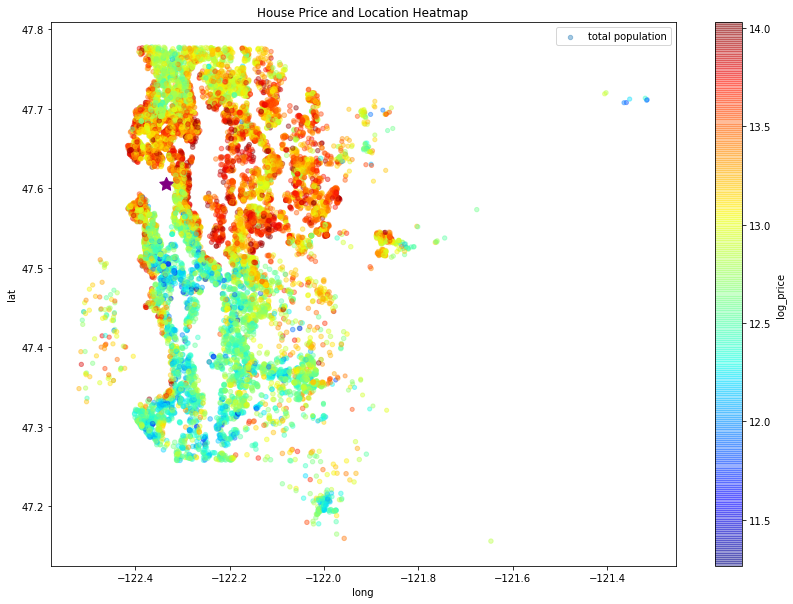

In [101]:
fig, ax = plt.subplots(figsize=(14,10))
housing_census_df_o.plot(kind="scatter", x="long", y="lat",
    s=housing_census_df_o['log_total_pop']*2,
    label="total population",
    c='log_price', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, ax=ax)

# Plot Downtown Seattle's location
plt.scatter(x=-122.3344,y=47.6050,data=housing_census_df,
            c='purple',
            s=200,
            marker=(5, 1))

plt.title('House Price and Location Heatmap')
plt.legend();

The above visual examines the distribution of log house price ($) after the outliers in Median Income and House price are removed. With the outliers removed, there is a more clear separation and visible spectrum of house price indicated by the blue, green, yellow, and red color scheme allowing the more expensive and mid-range housing to appear more prominently. 

Create mid_range dataframe to examine any obvious differences between housing_census_df and housing_census_df_o

In [102]:
housing_mid_range = housing_census_df_o[ (housing_census_df_o['price'] <= 600000) & (housing_census_df_o['price'] >= 300000)]

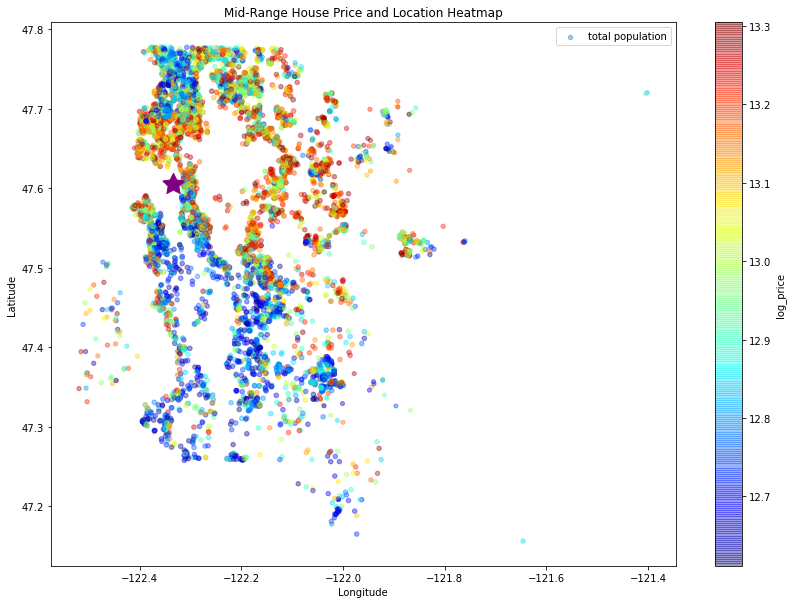

In [103]:
fig, ax = plt.subplots(figsize=(14,10))
housing_mid_range.plot(kind="scatter", x="long", y="lat",
    s=housing_mid_range['log_total_pop']*2, 
    label="total population",
    c='log_price', cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, ax=ax)
plt.title('Mid-Range House Price and Location Heatmap')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend()

# Plot Downtown Seattle's location
plt.scatter(x=-122.3344,y=47.6050,data=housing_census_df,
            c='purple',
            s=500,
            marker=(5, 1))

# Savefig
plt.savefig('MidRange_HousePriceandLocationMap_wSeattleMarker.jpg',dpi=300,bbox_inches = 'tight')

Focusing on the mid-range housing prices based on their location, there appears to be a slight separation between the more expensive houses in red located north of 47.5 latitude, and less expensive houses south of 47.5 latitude as distinguished by the red and blue regional coloring.

Let's aim to create a feature to specify this region to see if it can improve our model.

### Prepare new price_region feature

In [104]:
# Create new column to identify the region with more expensive houses
housing_census_df_o['price_region'] = housing_census_df_o['lat'].map(lambda x: True if x<=47.7 and x>=47.5 else False)

In [105]:
# Peek data
housing_census_df_o[['price','price_region']].head(10)

price  price_region
0    221900.0          True
1    538000.0         False
3   1230000.0          True
4    257500.0         False
5    468000.0          True
6    310000.0         False
7    400000.0          True
9    485000.0          True
10   189000.0         False
11   385000.0         False

Let's examine if there other features we can tease out from the housing mid range correlation matrix.

In [106]:
edu_cols = ['regular_high_school_diploma_25_years_and_over',
            'ged_or_alternative_credential_25_years_and_over',
            'some_college,_less_than_1_year_25_years_and_over',
            'some_college,_1_or_more_years,_no_degree_25_years_and_over',
            'associates_degree_25_years_and_over',
            'bachelors_degree_25_years_and_over',
            'masters_degree_25_years_and_over',
            'professional_school_degree_25_years_and_over',
            'doctorate_degree_25_years_and_over',
            'price']

In [107]:
mid_range_corr = housing_mid_range[edu_cols].corr()
mid_range_corr.tail(20)

regular_high_school_diploma_25_years_and_over  \
regular_high_school_diploma_25_years_and_over                                            1.000000   
ged_or_alternative_credential_25_years_and_over                                          0.872772   
some_college,_less_than_1_year_25_years_and_over                                         0.927742   
some_college,_1_or_more_years,_no_degree_25_yea...                                       0.805278   
associates_degree_25_years_and_over                                                      0.765386   
bachelors_degree_25_years_and_over                                                      -0.065036   
masters_degree_25_years_and_over                                                        -0.175740   
professional_school_degree_25_years_and_over                                            -0.378439   
doctorate_degree_25_years_and_over                                                      -0.278810   
price                                                                                   -0.397086   

                                                    ged_or_alternative_credential_25_years_and_over  \
regular_high_school_diploma_25_years_and_over                                              0.872772   
ged_or_alternative_credential_25_years_and_over                                            1.000000   
some_college,_less_than_1_year_25_years_and_over                                           0.819385   
some_college,_1_or_more_years,_no_degree_25_yea...                                         0.658029   
associates_degree_25_years_and_over                                                        0.608766   
bachelors_degree_25_years_and_over                                                        -0.164819   
masters_degree_25_years_and_over                                                          -0.271184   
professional_school_degree_25_years_and_over                                              -0.313426   
doctorate_degree_25_years_and_over                                                        -0.251861   
price                                                                                     -0.414008   

                                                    some_college,_less_than_1_year_25_years_and_over  \
regular_high_school_diploma_25_years_and_over                                               0.927742   
ged_or_alternative_credential_25_years_and_over                                             0.819385   
some_college,_less_than_1_year_25_years_and_over                                            1.000000   
some_college,_1_or_more_years,_no_degree_25_yea...                                          0.864482   
associates_degree_25_years_and_over                                                         0.826660   
bachelors_degree_25_years_and_over                                                          0.037313   
masters_degree_25_years_and_over                                                           -0.076624   
professional_school_degree_25_years_and_over                                               -0.307978   
doctorate_degree_25_years_and_over                                                         -0.209200   
price                                                                                      -0.354186   

                                                    some_college,_1_or_more_years,_no_degree_25_years_and_over  \
regular_high_school_diploma_25_years_and_over                                                0.805278            
ged_or_alternative_credential_25_years_and_over                                              0.658029            
some_college,_less_than_1_year_25_years_and_over                                             0.864482            
some_college,_1_or_more_years,_no_degree_25_yea...                                           1.000000            
associates_degree_25_years_and_over                                                        

In [108]:
# Generate a mask for the upper triangle
mask = np.zeros_like(mid_range_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

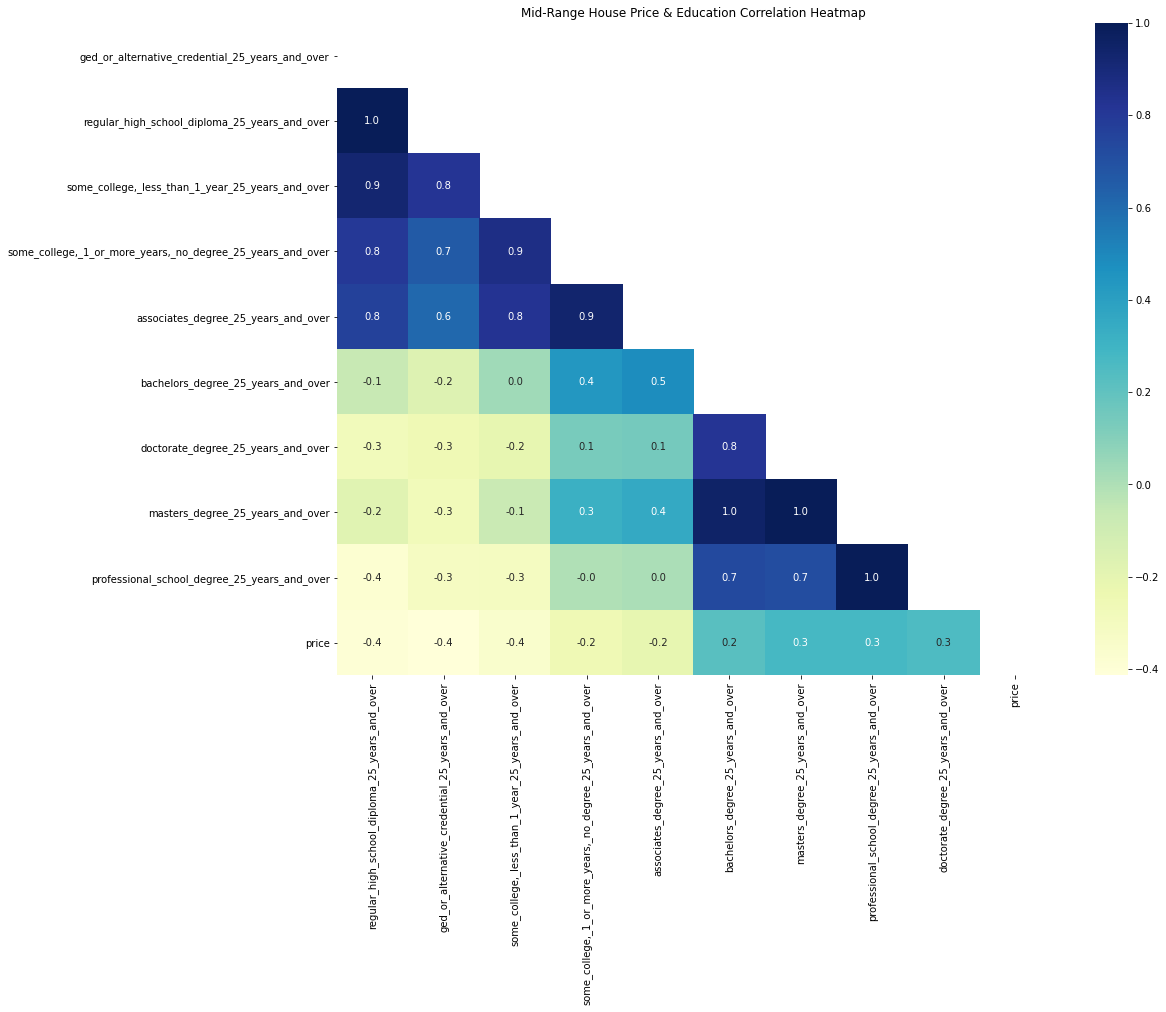

In [109]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap( mid_range_corr.sort_values('price'), mask=mask,cmap='YlGnBu',annot=True,fmt='1.1f', ax=ax )

plt.title('Mid-Range House Price & Education Correlation Heatmap')

# Savefig
plt.savefig('MidRange_HousePriceEducationHeatmap.jpg',dpi=300,bbox_inches = 'tight');

After filtering our dataframe focusing on the range of house prices with the largest residuals, we set up the heatmap correlation matrix to examine additional features that could help with the homoscadasticity issue we saw from model A. Including features from the census data, we can see that ged_or_alternative_credential_25_years_and_over has a moderately strong negative correlation that we can add.

## Model B

In [110]:
# Prep categorical column 'price_region' for model
price_region_labels = pd.get_dummies(housing_census_df_o['price_region'], prefix='price_region', drop_first=True)

In [111]:
# Model B - Feature Experimentation
housing_fin_df = pd.DataFrame([])

housing_fin_df['dist_downtown'] = dist_downtown
housing_fin_df['waterfront'] = waterfront_labels
housing_fin_df['price_region'] = price_region_labels

price = housing_census_df_o['price']
grade = housing_census_df_o['grade']

# Education cols
age = housing_census_df_o['median_age_total']
doc_edu = housing_census_df_o['doctorate_degree_25_years_and_over']
prof_edu = housing_census_df_o['professional_school_degree_25_years_and_over']
masters_edu = housing_census_df_o['masters_degree_25_years_and_over']
bach_edu = housing_census_df_o['bachelors_degree_25_years_and_over']
ged_edu = housing_census_df_o['ged_or_alternative_credential_25_years_and_over']
high_scool_edu = housing_census_df_o['regular_high_school_diploma_25_years_and_over']


housing_fin_df = pd.concat([price,
                            age,
                           ged_edu,
                           masters_edu,
                           housing_fin_df], axis=1)

In [112]:
housing_fin_df.dropna(inplace=True)
housing_fin_df.head()

price  median_age_total  \
0   221900.0                39   
1   538000.0                38   
3  1230000.0                41   
4   257500.0                36   
5   468000.0                38   

   ged_or_alternative_credential_25_years_and_over  \
0                                              785   
1                                              648   
3                                              119   
4                                             1217   
5                                              380   

   masters_degree_25_years_and_over  dist_downtown  waterfront  price_region  
0                               837      11.938179           0             1  
1                              3806      12.950085           0             0  
3                              2964      25.329222           0             1  
4                              1278      32.840620           0             0  
5                              6999       9.970998           0             1

In [113]:
outcome = 'price'
predictors = housing_fin_df.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

modelB = ols(formula=formula, data=housing_fin_df).fit()
modelB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     1448.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        22:38:30   Log-Likelihood:            -1.8045e+05
No. Observations:               13385   AIC:                         3.609e+05
Df Residuals:                   13378   BIC:                         3.610e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        3.777e+05   2.05e+04     18.388      0.000    3.37e+05    4.18e+05
median_age_total                                 3396.5725    461.196      7.365      0.000    2492.563    4300.582
ged_or_alternative_credential_25_years_and_over  -253.5960      5.919    -42.845      0.000    -265.198    -241.994
masters_degree_25_years_and_over                   22.3004      0.891     25.037      0.000      20.555      24.046
dist_downtown                                     -45.5387    179.623     -0.254      0.800    -397.625     306.548
waterfront                                       3.146e+05   2.57e+04     12.232      0.000    2.64e+05    3.65e+05
price_region                                     7.857e+04   4201.569     18.700      0.000    7.03e+04    8.68e+04
==============================================================================
Omnibus:                     1790.211   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2943.622
Skew:                           0.917   Prob(JB):                         0.00
Kurtosis:                       4.383   Cond. No.                     6.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model B Evaluation

Compared to our previous model, we took into consideration our newly created feature price_region, and a few of the correlated features seen in the housing mid_range heatmap. In addition to a house's distance to downtown, and whether a house has a waterfront, we are aiming to observe if a person's age, education, and the region of the home can better explain the variance in house prices compared to Model A. Collectively they explain only 39% of the variance in house prices, a 28% increase from Model A's 11%. 

According to our model:
- A house without regard to the provided features is expected to have a house price of 377,700 US dollars.
- For an increase in year of age, we expect house to increase roughly 3,396 US dollars
- For an additional km in the distance from downtown, we expect the house price to decrease by 45 US dollars
- Having a waterfront increases the house price by 314,600 US dollars
- Having a GED or alternative credential while being 25 years or older decreases the house price by 253 US dollars.
- Having a masters degree while being 25 years or older increases the house price by 22 US dollars.
- By having a house located between 47.5 and 47.7 latitude increases the price by 785,700 US dollars.

Based on the above message, we will check the variance inflation factor to confirm for the occurrence of multicollinearity.

### Multicollinearity Check

In [114]:
# Prep features for Model B

feature_list = ["ged_or_alternative_credential_25_years_and_over",
                 "masters_degree_25_years_and_over",
                 "median_age_total",
                 "waterfront",
                 "dist_downtown",
                 "price_region",
                 "price"]

rows = housing_fin_df[feature_list].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(feature_list))]
vif_df["feature"] = feature_list

vif_df

VIF                                          feature
0   4.732372  ged_or_alternative_credential_25_years_and_over
1   4.247557                 masters_degree_25_years_and_over
2  22.093225                                 median_age_total
3   1.018633                                       waterfront
4   6.122142                                    dist_downtown
5   3.690228                                     price_region
6   9.238437                                            price

Based on the above result, indeed there is a strong multicollinearity issues occurring. It appears there is a high VIF occurring particularly with **median_age_total**. Let us remove this feature and reassess the VIF.

### Multicollinearity Check without Age

In [115]:
# Set up VIF check with median_age_total removed

feature_list = ["ged_or_alternative_credential_25_years_and_over",
                "masters_degree_25_years_and_over",
                "waterfront",
                "dist_downtown",
                "price_region",
                "price"]

rows = housing_fin_df[feature_list].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(feature_list))]
vif_df["feature"] = feature_list

vif_df

VIF                                          feature
0  3.239715  ged_or_alternative_credential_25_years_and_over
1  4.045698                 masters_degree_25_years_and_over
2  1.018387                                       waterfront
3  4.335064                                    dist_downtown
4  3.212837                                     price_region
5  6.689156                                            price

After removing median_age_total, it appears to have significantly reduced the VIF for the other features, however dist_downtown appears a bit close to our threshold of 5. 

Based on this additional check, we will want to remove age as a feature in the next model.

Let us check on the other assumptions of linear regression.

### Linearity

In [116]:
rainbow_statistic, rainbow_p_value = linear_rainbow(modelB)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.041382725371829
Rainbow p-value: 0.04865256468315251


Based on the rainbow p-value being below our 0.05 threshold, returning a lower p-value means that the current model does violate the linearity assumption.

### Normality

<Figure size 864x576 with 0 Axes>

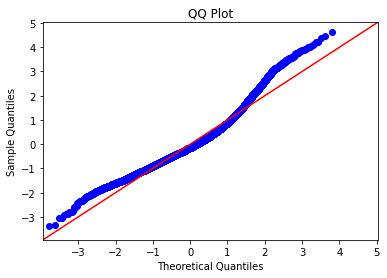

In [117]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(modelB.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

### Homoscadasticity

In [118]:
y = housing_fin_df['price']
y_hat = modelB.predict()

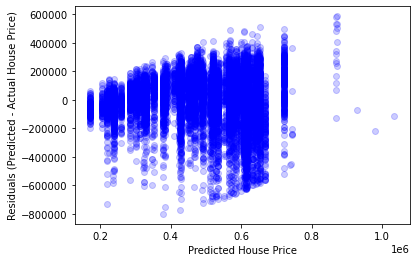

In [119]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel="Predicted House Price",
        ylabel="Residuals (Predicted - Actual House Price)")
ax2.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

## Model C

In [120]:
# Model C - Feature Experimentation
housing_fin_df = pd.DataFrame([])

housing_fin_df['waterfront'] = waterfront_labels
housing_fin_df['dist_downtown'] = dist_downtown
housing_fin_df['view'] = view
housing_fin_df['price_region'] = price_region_labels

price = housing_census_df_o['price']
grade = housing_census_df_o['grade']

# Education cols
age = housing_census_df_o['median_age_total']
doc_edu = housing_census_df_o['doctorate_degree_25_years_and_over']
prof_edu = housing_census_df_o['professional_school_degree_25_years_and_over']
masters_edu = housing_census_df_o['masters_degree_25_years_and_over']
bach_edu = housing_census_df_o['bachelors_degree_25_years_and_over']
ged_edu = housing_census_df_o['ged_or_alternative_credential_25_years_and_over']
high_scool_edu = housing_census_df_o['regular_high_school_diploma_25_years_and_over']


housing_fin_df = pd.concat([price,
                           ged_edu,
                           masters_edu,
                           housing_fin_df], axis=1)

In [121]:
outcome = 'price'
predictors = housing_fin_df.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

modelC = ols(formula=formula, data=housing_fin_df).fit()
modelC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1717.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        22:38:31   Log-Likelihood:            -1.6432e+05
No. Observations:               12239   AIC:                         3.287e+05
Df Residuals:                   12232   BIC:                         3.287e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        4.992e+05   6926.987     72.071      0.000    4.86e+05    5.13e+05
ged_or_alternative_credential_25_years_and_over  -259.3984      5.435    -47.727      0.000    -270.052    -248.745
masters_degree_25_years_and_over                   22.6175      0.874     25.883      0.000      20.905      24.330
waterfront                                       2.161e+04    2.7e+04      0.800      0.424   -3.13e+04    7.45e+04
dist_downtown                                    -221.0116    179.541     -1.231      0.218    -572.941     130.918
view                                             8.383e+04   2208.873     37.954      0.000    7.95e+04    8.82e+04
price_region                                     7.041e+04   4075.879     17.275      0.000    6.24e+04    7.84e+04
==============================================================================
Omnibus:                     1597.736   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2766.074
Skew:                           0.874   Prob(JB):                         0.00
Kurtosis:                       4.538   Cond. No.                     6.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model C Evaluation

Compared to model B, in this next iteration we removed age as a feature, and added whether a house has a view or not to the further investigate if aspects of location can help explain the variance in house prices. Collectively the removal of age and addition of view as features explain 46% of the variance in house prices. This is a 7% increase from Model B's reported 39%. 

According to our model:
- A house without regard to the provided features is expected to have a house price of 493,600 US dollars.
- For an additional km in the distance from downtown, we expect the house price to decrease by 222 US dollars. However, distance from downtown is also seen to have a p-value larger than our 0.05 threshold, therefore there is no correlation between distance from downtown and house price.
- Having a waterfront increases the house price by 21,610 US dollars. However, waterfront is also seen to have a p-value larger than our 0.05 threshold, therefore there is no correlation between waterfront and house price.
- Having a GED or alternative credential while being 25 years or older decreases the house price by 259 US dollars.
- Having a masters degree while being 25 years or older increases the house price by 22 US dollars.
- By having a house located between 47.5 and 47.7 latitude increases the price by 70,410 US dollars.
- By having a view, the house price increases by 83,830 US dollars

### Linearity

In [122]:
rainbow_statistic, rainbow_p_value = linear_rainbow(modelC)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.030938082811037
Rainbow p-value: 0.11676081830888412


With a p-value larger than our 0.05 threshold, we can say here we are not violating the linearity assumption.

### Normallity

<Figure size 864x576 with 0 Axes>

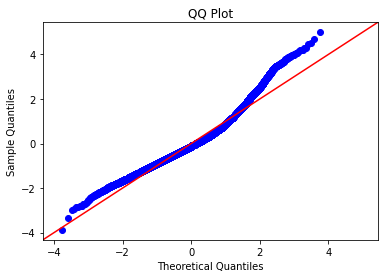

In [123]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(modelC.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

Assessing the QQ plot qualitatively, I would say this may be an acceptable form of normality.

### Homoscadasticity

In [124]:
housing_fin_df.dropna(inplace=True)

In [125]:
y = housing_fin_df['price']
y_hat = modelC.predict()

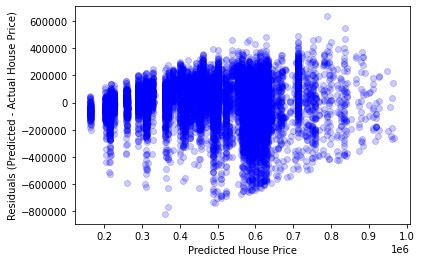

In [126]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel="Predicted House Price",
        ylabel="Residuals (Predicted - Actual House Price)")
ax2.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

After including the education level features, it appears there are still high residuals between the 500k and 600k US dollars house range. However, compared to our previous model, it does seem like we minimized the residuals within the 400k house price range.

### Multicollinearity Check

In [127]:
# Set up VIF check with median_age_total removed

feature_list = ["ged_or_alternative_credential_25_years_and_over",
                "masters_degree_25_years_and_over",
                "waterfront",
                "view",
                "dist_downtown",
                "price_region",
                "price"]

rows = housing_fin_df[feature_list].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(feature_list))]
vif_df["feature"] = feature_list

vif_df

VIF                                          feature
0  3.298886  ged_or_alternative_credential_25_years_and_over
1  4.216493                 masters_degree_25_years_and_over
2  1.003307                                       waterfront
3  1.208597                                             view
4  4.402294                                    dist_downtown
5  3.229279                                     price_region
6  7.329550                                            price

Compared to Model B where features median_age_total and dist_downtown exceeded our threshold of 5, the metrics from our latest VIF check are now below the threshold. While dist_downtown,ged_or_alternative_credential_25_years_and_over, and price_region may have higher VIF metrics suggesting there is stronger multicollinearity, I would say since they are not passed our threshold of 5, we can move forward with using these features. 

In [128]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, housing_fin_df[feature_list])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


# Summary

We first created a baseline model to evaluate a few of the features without any transformations or removal of outliers. The first features we focused on were distance from downtown (km), whether a house has a waterfront, and age. Our baseline model had an r-squared of 0.163. The model violated the linearity assumption with a p-value < 0.05, normality with an s-shaped qq-plot and a visible heavy right-skew, and lastly the model violated the homoscadasticity assumption with apparent cone-shaped residuals.

The next steps to improve our model are to remove outliers from 2 of the more highly skewed variables -- house price and household income. Removing these outliers reduced our dataset from 14622 to 13385 rows (1237 reduction).

Despite removing the outliers, in our next iteration of the model, modelA had a worse rsquared of 0.113. We examined the same features from the baseline model -- waterfront, houses distance from downtown (km), and age. ModelA also violated the linearity assumption (p-value < 0.05). Qualitatively, the QQ plot seemed to significantly improve by mitigating the right skew and s-shaped curve. However, from our residual plots, it still appears heteroscedastic. Examining the house price range where the residuals are largest, the house price ranges between 300k and 600k US dollars. From this, we examined if there are any characteristics of houses within this price range that we can tease out, and add to a next model iteration.

Filtering the dataset for houses within this price range, we observed that people with a ged_or_alternative_credential_25_years_and_over have the highest negative correlation and people buying houses with masters_degree_25_years_and_over have the highest positive correlation. Additionally, we were able to observe there is a specific region within Kings County that exhibit a clearer difference in house prices. Specifically, houses between 47.5 and 47.7 latitude tend to have more expensive houses while houses outside this region are less expensive. 

Using this newly discovered information, we created modelB adding new features to our original set. These new features include ged_or_alternative_credential_25_years_and_over, masters_degree_25_years_and_over, and price_region (houses located between 47.5 and 47.7 latitude). Collectively, the original and new features explain only 39% of the variance in house prices, a 28% increase from modelA's 11%. While this is a good first sign, it appears that after examining the variance inflation factor (VIF) for checking for multicollinearity amongst our features, our age feature, and distance from downtown (km) had a VIF metric of 22.09 and 6.12 respectively, far exceeding our threshold of 5. Given its high VIF metric, we removed age as a feature and repeated the VIF check. Through the second test, all features are now below our threshold of 5. Moreover, going through our linear regression assumption, modelB appears to violate the linearity and homoscadasticity assumption.

In our last model iteration, modelC, we the feature of whether a house has a view or not to the further investigate if aspects of location can help explain the variance in house prices. Collectively the removal of age and addition of view as features explain 46% of the variance in house prices. This is a 7% increase from Model B's reported 39%. The model did not violate the linearity assumption (p < 0.05), or the normality assumption. However, modelC's residuals exhibit a cone-shaped heteroscedastic characteristic.